In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split

from keras.layers import Input, Dense
from keras.models import Model

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray

Using TensorFlow backend.


In [2]:
np.random.seed(1120)

In [3]:
data = pd.read_csv('./data/AT.dat', delimiter="\t",
                   skiprows=[0], names=["k","r","x","A[k,r,x]"])
print(data.head())
data = data.to_numpy()

# Use first 8,056 points as training/validation and rest as test set.
train_data = data[0:8056]
test_data = data[8056:]

       k         r         x  A[k,r,x]
0  0.001  0.010817 -0.973907  1.009217
1  0.001  0.010817 -0.679410  1.009143
2  0.001  0.010817 -0.148874  1.009077
3  0.001  0.010817  0.148874  1.009077
4  0.001  0.010817  0.679410  1.009142


### Implementation
Now, we have a fair understanding of what GA is and how it works. Next, let’s get to coding.

We will use wind power forecast data, which is available at the following link. It consists of normalized (between zero and one) wind power measurements from seven wind farms. To keep things simple, we will use first wind farm data (column named wp1) but I encourage the reader to experiment and extend the code to forecast energy for all seven, wind farms.

Let’s import required packages, load the dataset and define two helper functions. The first method prepare_dataset will segment the data into chunks to create X, Y pair for model training. The X will the wind power values from the past (e.g. 1 to t-1) and Y will be future value at time t. The second method train_evaluate perform three things, 1) decoding GA solution to get window size and number of units. 2) Prepare the dataset using window size found by GA and divide into train and validation set, and 3) train LSTM model, calculate RMSE on validation set and return it as a fitness score of the current GA solution.

In [4]:
data[:,1].shape
data[:,0:3].shape[1]

3

In [5]:
np.zeros(11)[6:11]

array([0., 0., 0., 0., 0.])

In [6]:
def prepare_dataset(data):
    X, Y = np.empty((0)), np.empty((0))
    X = data[:,0:3]
    Y = data[:,3]  
    return X, Y

def train_evaluate(ga_individual_solution):   
    t = time.time()
    
    # Decode GA solution to integer for window_size and num_units
    deep_size_bits = BitArray(ga_individual_solution[0:3])
    num_units_bits = BitArray(ga_individual_solution[3:8])
    learning_rate_bits = BitArray(ga_individual_solution[8:12])
    batch_size_bits = BitArray(ga_individual_solution[12:14])
    epochs_bits = BitArray(ga_individual_solution[14:])
    
    deep_size = 2*deep_size_bits.uint +2
    num_units = 2*num_units_bits.uint +1
    learning_rate = (2*learning_rate_bits.uint+1)*10**(-4)
    batch_size = 2**(batch_size_bits.uint +1)
    epochs = (epochs_bits.uint +1)*50
    
    print('\nDeep Size: ', deep_size, ', Num of Units: ', num_units, ', Learning rate: ', learning_rate)
    print('Batch Size: ', batch_size, ", Num of Epochs: ", epochs)
    
    # Segment the train_data based on new window_size; split into train and validation (80/20)
    X,Y = prepare_dataset(train_data)
    X_train, X_test, y_train, y_test = split(X, Y, test_size = 0.20, random_state = 1120)
    
    # Train LSTM model and predict on validation set
    model = keras.Sequential()
    model.add(keras.Input(shape=(int(X_train.shape[1]),)))
    model.add(layers.Dense(num_units, input_shape=(int(X_train.shape[1]),)))
#     x = LSTM(num_units, input_shape=(window_size,1))(inputs)
    
    for i in range(deep_size):        
        model.add(layers.Dense(num_units, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0,
                                   patience=15,
                                   restore_best_weights=True)]
    model.fit(X_train, y_train, validation_data=(X_test, y_test),
              epochs=epochs, callbacks=callbacks, batch_size=batch_size, shuffle=True)
    y_pred = model.predict(X_test)
    
    # Calculate the RMSE score as fitness score for GA
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print('Validation RMSE: ', rmse)
    print('Time passed: ', time.time()-t)
    
    return rmse,

A continuación, use la paquetería DEAP para definir las cosas para ejecutar GA. Usaremos una representación binaria para la solución de longitud diez. Se inicializará aleatoriamente utilizando la distribución de Bernoulli. Del mismo modo, se utiliza el crossover ordenado, la mutación aleatoria y la selección de la rueda de la ruleta. Los valores del parámetro GA se inicializan arbitrariamente; Te sugerimos que juegues con diferentes configuraciones.



In [7]:
population_size = 20
num_generations = 20
gene_length = 15

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, 
n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, 
                        ngen = num_generations, verbose = True)


Deep Size:  10 , Num of Units:  33 , Learning rate:  0.0023
Batch Size:  8 , Num of Epochs:  50
Train on 6444 samples, validate on 1612 samples
Epoch 1/50
6444/6444 [==============================] - 12s 2ms/sample - loss: 0.4049 - val_loss: 0.0089
Epoch 2/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0033 - val_loss: 4.3088e-04
Epoch 3/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0015 - val_loss: 8.4391e-04
Epoch 4/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0011 - val_loss: 0.0020
Epoch 5/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 7.2274e-04 - val_loss: 3.6549e-04
Epoch 6/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.0014 - val_loss: 4.2033e-04
Epoch 7/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 7.1072e-04 - val_loss: 3.8073e-04
Epoch 8/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.5709e-04 - val_los

6444/6444 [==============================] - 22s 3ms/sample - loss: 2.4491e-04 - val_loss: 1.9807e-04
Epoch 21/100
6444/6444 [==============================] - 27s 4ms/sample - loss: 2.4612e-04 - val_loss: 1.8342e-04
Epoch 22/100
6444/6444 [==============================] - 22s 3ms/sample - loss: 2.3979e-04 - val_loss: 2.5018e-04
Epoch 23/100
6444/6444 [==============================] - 22s 3ms/sample - loss: 2.4995e-04 - val_loss: 2.0000e-04
Epoch 24/100
6444/6444 [==============================] - 23s 4ms/sample - loss: 2.7297e-04 - val_loss: 2.1982e-04
Epoch 25/100
6444/6444 [==============================] - 22s 3ms/sample - loss: 2.6601e-04 - val_loss: 2.2879e-04
Epoch 26/100
6444/6444 [==============================] - 23s 4ms/sample - loss: 2.4934e-04 - val_loss: 2.5989e-04
Epoch 27/100
6444/6444 [==============================] - 22s 3ms/sample - loss: 0.0015 - val_loss: 2.9515e-04
Epoch 28/100
6444/6444 [==============================] - 23s 4ms/sample - loss: 2.4886e-04 - val

6444/6444 [==============================] - 31s 5ms/sample - loss: 1.8466e-04 - val_loss: 1.6467e-04
Epoch 44/100
6444/6444 [==============================] - 30s 5ms/sample - loss: 1.8116e-04 - val_loss: 1.5052e-04
Epoch 45/100
6444/6444 [==============================] - 31s 5ms/sample - loss: 1.8041e-04 - val_loss: 1.5272e-04
Epoch 46/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 1.8221e-04 - val_loss: 2.8347e-04
Epoch 47/100
6444/6444 [==============================] - 31s 5ms/sample - loss: 1.8329e-04 - val_loss: 1.3201e-04
Epoch 48/100
6444/6444 [==============================] - 31s 5ms/sample - loss: 1.8222e-04 - val_loss: 1.3272e-04
Epoch 49/100
6444/6444 [==============================] - 31s 5ms/sample - loss: 1.7190e-04 - val_loss: 1.4520e-04
Epoch 50/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 1.6967e-04 - val_loss: 2.3955e-04
Epoch 51/100
6444/6444 [==============================] - 30s 5ms/sample - loss: 1.6948e-04 -

6444/6444 [==============================] - 12s 2ms/sample - loss: 0.0014 - val_loss: 3.8340e-04
Epoch 26/50
6444/6444 [==============================] - 12s 2ms/sample - loss: 3.7586e-04 - val_loss: 4.3360e-04
Epoch 27/50
6444/6444 [==============================] - 12s 2ms/sample - loss: 4.2340e-04 - val_loss: 3.8449e-04
Epoch 28/50
6444/6444 [==============================] - 12s 2ms/sample - loss: 3.4495e-04 - val_loss: 3.3833e-04
Validation RMSE:  0.01569564724209624
Time passed:  347.02828645706177

Deep Size:  4 , Num of Units:  53 , Learning rate:  0.0005
Batch Size:  16 , Num of Epochs:  50
Train on 6444 samples, validate on 1612 samples
Epoch 1/50
6444/6444 [==============================] - 6s 975us/sample - loss: 49.0087 - val_loss: 1.3094
Epoch 2/50
6444/6444 [==============================] - 3s 504us/sample - loss: 48.1528 - val_loss: 8.7289
Epoch 3/50
6444/6444 [==============================] - 3s 450us/sample - loss: 21.9643 - val_loss: 1.6847
Epoch 4/50
6444/6444 [=

6444/6444 [==============================] - 21s 3ms/sample - loss: 4.8230e-04 - val_loss: 3.8334e-04
Epoch 18/100
6444/6444 [==============================] - 21s 3ms/sample - loss: 5.3179e-04 - val_loss: 4.3867e-04
Epoch 19/100
6444/6444 [==============================] - 21s 3ms/sample - loss: 0.0993 - val_loss: 7.9359e-04
Epoch 20/100
6444/6444 [==============================] - 21s 3ms/sample - loss: 5.0384e-04 - val_loss: 5.5342e-04
Epoch 21/100
6444/6444 [==============================] - 21s 3ms/sample - loss: 4.5390e-04 - val_loss: 3.3737e-04
Epoch 22/100
6444/6444 [==============================] - 22s 3ms/sample - loss: 0.0235 - val_loss: 4.3980e-04
Epoch 23/100
6444/6444 [==============================] - 21s 3ms/sample - loss: 6.6915e-04 - val_loss: 3.2475e-04
Epoch 24/100
6444/6444 [==============================] - 22s 3ms/sample - loss: 0.0096 - val_loss: 4.1268e-04
Epoch 25/100
6444/6444 [==============================] - 22s 3ms/sample - loss: 5.7092e-04 - val_loss: 4

6444/6444 [==============================] - 7s 1ms/sample - loss: 2.3504e-04 - val_loss: 2.8143e-04
Epoch 45/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.2823e-04 - val_loss: 2.1229e-04
Epoch 46/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.0800e-04 - val_loss: 1.8686e-04
Epoch 47/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.0523e-04 - val_loss: 2.0490e-04
Epoch 48/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.3585e-04 - val_loss: 1.8607e-04
Epoch 49/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.0006e-04 - val_loss: 1.7916e-04
Epoch 50/100
6444/6444 [==============================] - 5s 782us/sample - loss: 2.0232e-04 - val_loss: 3.0046e-04
Epoch 51/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.9741e-04 - val_loss: 1.8733e-04
Epoch 52/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.9357e-04 - val_lo

6444/6444 [==============================] - 8s 1ms/sample - loss: 2.3808e-04 - val_loss: 2.4224e-04
Epoch 32/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.2333e-04 - val_loss: 1.9207e-04
Epoch 33/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.3085e-04 - val_loss: 1.9099e-04
Epoch 34/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.2456e-04 - val_loss: 2.0467e-04
Epoch 35/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.1544e-04 - val_loss: 2.0924e-04
Epoch 36/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.3444e-04 - val_loss: 1.7384e-04
Epoch 37/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.1108e-04 - val_loss: 1.9519e-04
Epoch 38/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.0937e-04 - val_loss: 1.7696e-04
Epoch 39/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.1373e-04 - val_loss

Epoch 45/100
6444/6444 [==============================] - 4s 607us/sample - loss: 2.4534e-04 - val_loss: 2.7445e-04
Epoch 46/100
6444/6444 [==============================] - 4s 596us/sample - loss: 2.2961e-04 - val_loss: 1.9962e-04
Epoch 47/100
6444/6444 [==============================] - 4s 612us/sample - loss: 2.5021e-04 - val_loss: 2.4000e-04
Epoch 48/100
6444/6444 [==============================] - 4s 571us/sample - loss: 2.2914e-04 - val_loss: 2.0621e-04
Epoch 49/100
6444/6444 [==============================] - 4s 600us/sample - loss: 3.3255e-04 - val_loss: 2.5017e-04
Epoch 50/100
6444/6444 [==============================] - 4s 605us/sample - loss: 2.2764e-04 - val_loss: 1.8819e-04
Epoch 51/100
6444/6444 [==============================] - 4s 609us/sample - loss: 2.1753e-04 - val_loss: 2.0595e-04
Epoch 52/100
6444/6444 [==============================] - 4s 579us/sample - loss: 2.3754e-04 - val_loss: 2.1996e-04
Epoch 53/100
6444/6444 [==============================] - 4s 573us/sampl

6444/6444 [==============================] - 4s 613us/sample - loss: 3.2818e-04 - val_loss: 3.1145e-04
Epoch 29/100
6444/6444 [==============================] - 3s 499us/sample - loss: 2.9821e-04 - val_loss: 2.7704e-04
Epoch 30/100
6444/6444 [==============================] - 4s 608us/sample - loss: 3.9658e-04 - val_loss: 0.0012
Epoch 31/100
6444/6444 [==============================] - 4s 602us/sample - loss: 0.0039 - val_loss: 7.6905e-04
Epoch 32/100
6444/6444 [==============================] - 4s 602us/sample - loss: 0.0021 - val_loss: 3.4168e-04
Epoch 33/100
6444/6444 [==============================] - 4s 600us/sample - loss: 5.7193e-04 - val_loss: 0.0026
Epoch 34/100
6444/6444 [==============================] - 4s 600us/sample - loss: 0.0017 - val_loss: 5.6133e-04
Epoch 35/100
6444/6444 [==============================] - 4s 607us/sample - loss: 4.9786e-04 - val_loss: 2.5954e-04
Epoch 36/100
6444/6444 [==============================] - 4s 610us/sample - loss: 2.6512e-04 - val_loss: 

Epoch 7/50
6444/6444 [==============================] - 18s 3ms/sample - loss: 4.0133e-04 - val_loss: 2.8096e-04
Epoch 8/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 3.3222e-04 - val_loss: 3.5219e-04
Epoch 9/50
6444/6444 [==============================] - 17s 3ms/sample - loss: 3.4507e-04 - val_loss: 4.3036e-04
Epoch 10/50
6444/6444 [==============================] - 17s 3ms/sample - loss: 4.2339e-04 - val_loss: 2.8997e-04
Epoch 11/50
6444/6444 [==============================] - 16s 2ms/sample - loss: 3.4309e-04 - val_loss: 2.7924e-04
Epoch 12/50
6444/6444 [==============================] - 18s 3ms/sample - loss: 3.1480e-04 - val_loss: 2.5547e-04
Epoch 13/50
6444/6444 [==============================] - 16s 2ms/sample - loss: 2.7604e-04 - val_loss: 2.5710e-04
Epoch 14/50
6444/6444 [==============================] - 18s 3ms/sample - loss: 2.8247e-04 - val_loss: 2.5487e-04
Epoch 15/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 2.7190e-04 

6444/6444 [==============================] - 33s 5ms/sample - loss: 3.0588e-04 - val_loss: 2.8327e-04
Epoch 28/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 3.4715e-04 - val_loss: 3.2954e-04
Epoch 29/100
6444/6444 [==============================] - 33s 5ms/sample - loss: 3.2563e-04 - val_loss: 3.3069e-04
Epoch 30/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 3.1995e-04 - val_loss: 2.8646e-04
Epoch 31/100
6444/6444 [==============================] - 28s 4ms/sample - loss: 3.2384e-04 - val_loss: 3.4382e-04
Epoch 32/100
6444/6444 [==============================] - 33s 5ms/sample - loss: 3.0139e-04 - val_loss: 3.1910e-04
Epoch 33/100
6444/6444 [==============================] - 31s 5ms/sample - loss: 2.9714e-04 - val_loss: 2.5315e-04
Epoch 34/100
6444/6444 [==============================] - 30s 5ms/sample - loss: 2.8233e-04 - val_loss: 2.6182e-04
Epoch 35/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 3.1432e-04 -

6444/6444 [==============================] - 28s 4ms/sample - loss: 6.4374e-04 - val_loss: 7.1332e-04
Epoch 3/100
6444/6444 [==============================] - 31s 5ms/sample - loss: 6.3397e-04 - val_loss: 3.8790e-04
Epoch 4/100
6444/6444 [==============================] - 29s 4ms/sample - loss: 5.1167e-04 - val_loss: 5.1733e-04
Epoch 5/100
6444/6444 [==============================] - 31s 5ms/sample - loss: 4.5128e-04 - val_loss: 5.5888e-04
Epoch 6/100
6444/6444 [==============================] - 33s 5ms/sample - loss: 4.4252e-04 - val_loss: 4.0189e-04
Epoch 7/100
6444/6444 [==============================] - 29s 4ms/sample - loss: 3.9757e-04 - val_loss: 2.7842e-04
Epoch 8/100
6444/6444 [==============================] - 36s 6ms/sample - loss: 3.7284e-04 - val_loss: 2.8619e-04
Epoch 9/100
6444/6444 [==============================] - 30s 5ms/sample - loss: 3.6684e-04 - val_loss: 2.8850e-04
Epoch 10/100
6444/6444 [==============================] - 29s 4ms/sample - loss: 3.5557e-04 - val_lo

6444/6444 [==============================] - 15s 2ms/sample - loss: 5.7180e-04 - val_loss: 6.6341e-04
Epoch 14/50
6444/6444 [==============================] - 15s 2ms/sample - loss: 3.2722e-04 - val_loss: 2.4735e-04
Epoch 15/50
6444/6444 [==============================] - 15s 2ms/sample - loss: 3.1990e-04 - val_loss: 2.3993e-04
Epoch 16/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 3.7620e-04 - val_loss: 3.2158e-04
Epoch 17/50
6444/6444 [==============================] - 15s 2ms/sample - loss: 6.1255e-04 - val_loss: 2.9598e-04
Epoch 18/50
6444/6444 [==============================] - 15s 2ms/sample - loss: 3.2097e-04 - val_loss: 5.2838e-04
Epoch 19/50
6444/6444 [==============================] - 15s 2ms/sample - loss: 3.0947e-04 - val_loss: 2.9048e-04
Epoch 20/50
6444/6444 [==============================] - 15s 2ms/sample - loss: 2.8177e-04 - val_loss: 2.2348e-04
Epoch 21/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.0030 - val_loss: 4

Epoch 37/100
6444/6444 [==============================] - 4s 653us/sample - loss: 2.1268e-04 - val_loss: 2.3079e-04
Epoch 38/100
6444/6444 [==============================] - 4s 548us/sample - loss: 2.2366e-04 - val_loss: 1.8452e-04
Epoch 39/100
6444/6444 [==============================] - 5s 732us/sample - loss: 1.9862e-04 - val_loss: 1.8403e-04
Epoch 40/100
6444/6444 [==============================] - 5s 730us/sample - loss: 1.9913e-04 - val_loss: 2.1880e-04
Epoch 41/100
6444/6444 [==============================] - 4s 676us/sample - loss: 2.0055e-04 - val_loss: 3.2947e-04
Epoch 42/100
6444/6444 [==============================] - 4s 693us/sample - loss: 2.1017e-04 - val_loss: 2.1481e-04
Epoch 43/100
6444/6444 [==============================] - 4s 689us/sample - loss: 2.0025e-04 - val_loss: 2.1935e-04
Epoch 44/100
6444/6444 [==============================] - 4s 690us/sample - loss: 2.0192e-04 - val_loss: 3.3936e-04
Epoch 45/100
6444/6444 [==============================] - 3s 487us/sampl

6444/6444 [==============================] - 9s 1ms/sample - loss: 3.0089e-04 - val_loss: 2.9048e-04
Epoch 22/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 4.8679e-04 - val_loss: 4.2870e-04
Epoch 23/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 3.0810e-04 - val_loss: 3.4282e-04
Epoch 24/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.7886e-04 - val_loss: 2.7738e-04
Epoch 25/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.6808e-04 - val_loss: 2.2406e-04
Epoch 26/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.5692e-04 - val_loss: 2.1807e-04
Epoch 27/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.5430e-04 - val_loss: 3.5270e-04
Epoch 28/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.4215e-04 - val_loss: 2.6054e-04
Epoch 29/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.3651e-04 - val_loss: 2.5352

6444/6444 [==============================] - 30s 5ms/sample - loss: 0.0529 - val_loss: 0.0086
Epoch 4/50
6444/6444 [==============================] - 29s 4ms/sample - loss: 0.0217 - val_loss: 0.0054
Epoch 5/50
6444/6444 [==============================] - 29s 4ms/sample - loss: 0.0134 - val_loss: 0.0021
Epoch 6/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.0142 - val_loss: 7.1566e-04
Epoch 7/50
6444/6444 [==============================] - 30s 5ms/sample - loss: 0.0114 - val_loss: 8.9760e-04
Epoch 8/50
6444/6444 [==============================] - 29s 5ms/sample - loss: 0.0062 - val_loss: 0.0017
Epoch 9/50
6444/6444 [==============================] - 30s 5ms/sample - loss: 0.0052 - val_loss: 5.8900e-04
Epoch 10/50
6444/6444 [==============================] - 27s 4ms/sample - loss: 0.0017 - val_loss: 4.5216e-04
Epoch 11/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.0022 - val_loss: 5.0941e-04
Epoch 12/50
6444/6444 [=====================

Epoch 25/100
6444/6444 [==============================] - 3s 418us/sample - loss: 2.9014 - val_loss: 0.1284
Epoch 26/100
6444/6444 [==============================] - 3s 418us/sample - loss: 0.1120 - val_loss: 0.0134
Epoch 27/100
6444/6444 [==============================] - 3s 434us/sample - loss: 0.0060 - val_loss: 9.8860e-04
Epoch 28/100
6444/6444 [==============================] - 3s 423us/sample - loss: 2.1352 - val_loss: 0.0055
Epoch 29/100
6444/6444 [==============================] - 3s 412us/sample - loss: 1.0205 - val_loss: 0.3978
Epoch 30/100
6444/6444 [==============================] - 3s 415us/sample - loss: 0.0088 - val_loss: 0.0075
Epoch 31/100
6444/6444 [==============================] - 3s 416us/sample - loss: 4.2850 - val_loss: 0.0096
Epoch 32/100
6444/6444 [==============================] - 3s 421us/sample - loss: 0.0056 - val_loss: 0.0023
Epoch 33/100
6444/6444 [==============================] - 3s 417us/sample - loss: 0.0015 - val_loss: 9.0700e-04
Epoch 34/100
6444/64

6444/6444 [==============================] - 8s 1ms/sample - loss: 2.5846e-04 - val_loss: 2.3599e-04
Epoch 29/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.5004e-04 - val_loss: 2.2934e-04
Epoch 30/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.4635e-04 - val_loss: 3.1758e-04
Epoch 31/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.3116e-04 - val_loss: 2.2941e-04
Epoch 32/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.3161e-04 - val_loss: 2.3029e-04
Epoch 33/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.2352e-04 - val_loss: 2.0914e-04
Epoch 34/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.2579e-04 - val_loss: 2.1157e-04
Epoch 35/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.1103e-04 - val_loss: 2.3226e-04
Epoch 36/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.0966e-04 - val_loss

Epoch 100/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 1.3696e-04 - val_loss: 1.1638e-04
Validation RMSE:  0.010788170417416277
Time passed:  752.5807728767395
gen	nevals
0  	20    

Deep Size:  10 , Num of Units:  33 , Learning rate:  0.00030000000000000003
Batch Size:  2 , Num of Epochs:  100
Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 33s 5ms/sample - loss: 0.2669 - val_loss: 0.1489
Epoch 2/100
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.0168 - val_loss: 0.0020
Epoch 3/100
6444/6444 [==============================] - 29s 4ms/sample - loss: 0.0154 - val_loss: 0.0064
Epoch 4/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 0.0234 - val_loss: 0.0737
Epoch 5/100
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.0050 - val_loss: 0.0013
Epoch 6/100
6444/6444 [==============================] - 29s 5ms/sample - loss: 0.0068 - val_loss: 4

6444/6444 [==============================] - 13s 2ms/sample - loss: 1.6006 - val_loss: 0.0277
Epoch 2/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.0368 - val_loss: 0.0214
Epoch 3/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.0091 - val_loss: 0.0136
Epoch 4/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0078 - val_loss: 0.0030
Epoch 5/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.0179 - val_loss: 0.0065
Epoch 6/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.0036 - val_loss: 0.0014
Epoch 7/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.0015 - val_loss: 7.3053e-04
Epoch 8/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 8.0874e-04 - val_loss: 8.4549e-04
Epoch 9/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 6.8586e-04 - val_loss: 5.6109e-04
Epoch 10/100
6444/6444 [======================

6444/6444 [==============================] - 9s 1ms/sample - loss: 2.7023e-04 - val_loss: 2.5801e-04
Epoch 74/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.7106e-04 - val_loss: 2.9174e-04
Epoch 75/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.7276e-04 - val_loss: 3.1474e-04
Epoch 76/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.6610e-04 - val_loss: 2.6334e-04
Epoch 77/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.7311e-04 - val_loss: 2.5953e-04
Epoch 78/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.6616e-04 - val_loss: 2.6100e-04
Epoch 79/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.7201e-04 - val_loss: 2.7356e-04
Epoch 80/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.6716e-04 - val_loss: 2.6816e-04
Epoch 81/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.6456e-04 - val_loss

6444/6444 [==============================] - 33s 5ms/sample - loss: 2.4418e-04 - val_loss: 2.0704e-04
Epoch 43/100
6444/6444 [==============================] - 30s 5ms/sample - loss: 2.4556e-04 - val_loss: 2.3117e-04
Epoch 44/100
6444/6444 [==============================] - 33s 5ms/sample - loss: 2.4210e-04 - val_loss: 2.4606e-04
Epoch 45/100
6444/6444 [==============================] - 31s 5ms/sample - loss: 2.3733e-04 - val_loss: 2.0519e-04
Epoch 46/100
6444/6444 [==============================] - 31s 5ms/sample - loss: 2.3376e-04 - val_loss: 1.8594e-04
Epoch 47/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.3647e-04 - val_loss: 3.3132e-04
Epoch 48/100
6444/6444 [==============================] - 33s 5ms/sample - loss: 2.3191e-04 - val_loss: 2.2932e-04
Epoch 49/100
6444/6444 [==============================] - 30s 5ms/sample - loss: 2.2480e-04 - val_loss: 2.2202e-04
Epoch 50/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.3050e-04 -

6444/6444 [==============================] - 32s 5ms/sample - loss: 2.1580e-04 - val_loss: 1.8749e-04
Epoch 51/100
6444/6444 [==============================] - 33s 5ms/sample - loss: 2.1992e-04 - val_loss: 2.1235e-04
Epoch 52/100
6444/6444 [==============================] - 31s 5ms/sample - loss: 2.1540e-04 - val_loss: 2.2819e-04
Epoch 53/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.1341e-04 - val_loss: 2.0011e-04
Epoch 54/100
6444/6444 [==============================] - 33s 5ms/sample - loss: 2.1738e-04 - val_loss: 2.1033e-04
Epoch 55/100
6444/6444 [==============================] - 31s 5ms/sample - loss: 2.1305e-04 - val_loss: 1.9616e-04
Epoch 56/100
6444/6444 [==============================] - 33s 5ms/sample - loss: 2.1225e-04 - val_loss: 1.8372e-04
Epoch 57/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.0990e-04 - val_loss: 1.9715e-04
Epoch 58/100
6444/6444 [==============================] - 33s 5ms/sample - loss: 2.1239e-04 -

Epoch 20/50
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.3386e-04 - val_loss: 2.7755e-04
Epoch 21/50
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.2897e-04 - val_loss: 2.1104e-04
Epoch 22/50
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.3669e-04 - val_loss: 2.6228e-04
Epoch 23/50
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.2526e-04 - val_loss: 1.9177e-04
Epoch 24/50
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.2896e-04 - val_loss: 2.0142e-04
Epoch 25/50
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.2515e-04 - val_loss: 2.8021e-04
Epoch 26/50
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.4752e-04 - val_loss: 2.7751e-04
Epoch 27/50
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.4530e-04 - val_loss: 3.1540e-04
Epoch 28/50
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.3695e-

6444/6444 [==============================] - 7s 1ms/sample - loss: 2.0217e-04 - val_loss: 2.6019e-04
Epoch 41/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.9888e-04 - val_loss: 1.6871e-04
Epoch 42/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.1349e-04 - val_loss: 1.8368e-04
Epoch 43/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.0602e-04 - val_loss: 1.8487e-04
Epoch 44/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.0351e-04 - val_loss: 2.2787e-04
Epoch 45/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.0490e-04 - val_loss: 1.8251e-04
Epoch 46/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.1166e-04 - val_loss: 1.8328e-04
Epoch 47/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.9991e-04 - val_loss: 1.8615e-04
Epoch 48/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.9806e-04 - val_loss

6444/6444 [==============================] - 2s 364us/sample - loss: 0.3503 - val_loss: 0.0371
Epoch 11/100
6444/6444 [==============================] - 2s 366us/sample - loss: 9.4819 - val_loss: 14.0943
Epoch 12/100
6444/6444 [==============================] - 2s 365us/sample - loss: 11.2398 - val_loss: 0.0802
Epoch 13/100
6444/6444 [==============================] - 2s 370us/sample - loss: 16.1422 - val_loss: 724.4048
Epoch 14/100
6444/6444 [==============================] - 2s 367us/sample - loss: 26.5347 - val_loss: 0.0059
Epoch 15/100
6444/6444 [==============================] - 2s 368us/sample - loss: 0.0062 - val_loss: 0.0038
Epoch 16/100
6444/6444 [==============================] - 2s 367us/sample - loss: 0.0036 - val_loss: 0.0028
Epoch 17/100
6444/6444 [==============================] - 2s 369us/sample - loss: 44.8347 - val_loss: 9.6742e-04
Epoch 18/100
6444/6444 [==============================] - 2s 370us/sample - loss: 8.7860e-04 - val_loss: 8.7851e-04
Epoch 19/100
6444/6444

6444/6444 [==============================] - 2s 374us/sample - loss: 3.0283e-04 - val_loss: 3.4401e-04
Epoch 82/100
6444/6444 [==============================] - 2s 370us/sample - loss: 3.2290e-04 - val_loss: 5.6717e-04
Epoch 83/100
6444/6444 [==============================] - 2s 366us/sample - loss: 3.3591e-04 - val_loss: 2.8779e-04
Epoch 84/100
6444/6444 [==============================] - 2s 370us/sample - loss: 3.0854e-04 - val_loss: 3.4996e-04
Epoch 85/100
6444/6444 [==============================] - 2s 366us/sample - loss: 3.2118e-04 - val_loss: 3.9626e-04
Epoch 86/100
6444/6444 [==============================] - 2s 376us/sample - loss: 3.1841e-04 - val_loss: 3.7103e-04
Epoch 87/100
6444/6444 [==============================] - 2s 372us/sample - loss: 3.0749e-04 - val_loss: 2.7489e-04
Epoch 88/100
6444/6444 [==============================] - 2s 371us/sample - loss: 3.1510e-04 - val_loss: 2.6934e-04
Epoch 89/100
6444/6444 [==============================] - 2s 372us/sample - loss: 3.8

Validation RMSE:  0.012926357883195466
Time passed:  663.689346075058

Deep Size:  8 , Num of Units:  49 , Learning rate:  0.00030000000000000003
Batch Size:  16 , Num of Epochs:  100
Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 6s 922us/sample - loss: 1.7031 - val_loss: 2.1245
Epoch 2/100
6444/6444 [==============================] - 3s 520us/sample - loss: 0.4231 - val_loss: 0.9943
Epoch 3/100
6444/6444 [==============================] - 3s 518us/sample - loss: 0.0312 - val_loss: 0.0048
Epoch 4/100
6444/6444 [==============================] - 3s 515us/sample - loss: 0.0151 - val_loss: 0.0085
Epoch 5/100
6444/6444 [==============================] - 3s 517us/sample - loss: 0.0036 - val_loss: 0.0010
Epoch 6/100
6444/6444 [==============================] - 3s 526us/sample - loss: 0.0032 - val_loss: 0.0071
Epoch 7/100
6444/6444 [==============================] - 3s 518us/sample - loss: 0.0043 - val_loss: 0.0089
Epoch 8/100
6444/64

6444/6444 [==============================] - 3s 521us/sample - loss: 0.0015 - val_loss: 2.4924e-04
Epoch 72/100
6444/6444 [==============================] - 3s 517us/sample - loss: 3.7339e-04 - val_loss: 2.5186e-04
Epoch 73/100
6444/6444 [==============================] - 3s 519us/sample - loss: 2.4656e-04 - val_loss: 2.5462e-04
Epoch 74/100
6444/6444 [==============================] - 3s 521us/sample - loss: 4.0369e-04 - val_loss: 2.1790e-04
Epoch 75/100
6444/6444 [==============================] - 3s 520us/sample - loss: 2.1725e-04 - val_loss: 2.0873e-04
Epoch 76/100
6444/6444 [==============================] - 3s 519us/sample - loss: 4.2971e-04 - val_loss: 2.3113e-04
Epoch 77/100
6444/6444 [==============================] - 3s 513us/sample - loss: 2.6140e-04 - val_loss: 2.2138e-04
Epoch 78/100
6444/6444 [==============================] - 3s 519us/sample - loss: 2.2404e-04 - val_loss: 2.3442e-04
Epoch 79/100
6444/6444 [==============================] - 3s 518us/sample - loss: 2.2409e

6444/6444 [==============================] - 9s 1ms/sample - loss: 1.7805e-04 - val_loss: 1.4521e-04
Epoch 58/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.0756e-04 - val_loss: 1.9959e-04
Epoch 59/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.0596e-04 - val_loss: 2.3443e-04
Epoch 60/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.7949e-04 - val_loss: 1.7083e-04
Epoch 61/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.8302e-04 - val_loss: 1.5929e-04
Epoch 62/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.8820e-04 - val_loss: 2.7868e-04
Epoch 63/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.8158e-04 - val_loss: 1.2620e-04
Epoch 64/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 1.9113e-04 - val_loss: 1.4777e-04
Epoch 65/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 1.8637e-04 - val_loss

6444/6444 [==============================] - 16s 3ms/sample - loss: 2.1639e-04 - val_loss: 2.5137e-04
Epoch 28/50
6444/6444 [==============================] - 17s 3ms/sample - loss: 2.1556e-04 - val_loss: 3.1039e-04
Epoch 29/50
6444/6444 [==============================] - 12s 2ms/sample - loss: 2.2778e-04 - val_loss: 1.8663e-04
Epoch 30/50
6444/6444 [==============================] - 16s 2ms/sample - loss: 2.1558e-04 - val_loss: 3.3709e-04
Epoch 31/50
6444/6444 [==============================] - 16s 3ms/sample - loss: 2.2124e-04 - val_loss: 2.4085e-04
Epoch 32/50
6444/6444 [==============================] - 16s 2ms/sample - loss: 2.2138e-04 - val_loss: 2.2903e-04
Epoch 33/50
6444/6444 [==============================] - 16s 3ms/sample - loss: 2.1253e-04 - val_loss: 1.6565e-04
Epoch 34/50
6444/6444 [==============================] - 16s 2ms/sample - loss: 2.1007e-04 - val_loss: 1.7351e-04
Epoch 35/50
6444/6444 [==============================] - 16s 2ms/sample - loss: 2.1555e-04 - val_los

6444/6444 [==============================] - 2s 364us/sample - loss: 1.3198 - val_loss: 0.1883
Epoch 50/100
6444/6444 [==============================] - 2s 364us/sample - loss: 22.4946 - val_loss: 0.0106
Epoch 51/100
6444/6444 [==============================] - 2s 365us/sample - loss: 0.0173 - val_loss: 0.0120
Epoch 52/100
6444/6444 [==============================] - 2s 365us/sample - loss: 0.0104 - val_loss: 0.0080
Epoch 53/100
6444/6444 [==============================] - 2s 368us/sample - loss: 0.0071 - val_loss: 0.0053
Epoch 54/100
6444/6444 [==============================] - 2s 367us/sample - loss: 0.0046 - val_loss: 0.0071
Epoch 55/100
6444/6444 [==============================] - 2s 367us/sample - loss: 0.0026 - val_loss: 0.0100
Epoch 56/100
6444/6444 [==============================] - 2s 365us/sample - loss: 0.0046 - val_loss: 0.0040
Epoch 57/100
6444/6444 [==============================] - 2s 367us/sample - loss: 0.0029 - val_loss: 0.0026
Epoch 58/100
6444/6444 [================

6444/6444 [==============================] - 11s 2ms/sample - loss: 1219.1664 - val_loss: 0.2955
Epoch 2/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 2471.0881 - val_loss: 67.0029
Epoch 3/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 8.2055 - val_loss: 15.0956
Epoch 4/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 675.3933 - val_loss: 0.0546
Epoch 5/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.0941 - val_loss: 0.0385
Epoch 6/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 63.6827 - val_loss: 0.0010
Epoch 7/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.1275 - val_loss: 0.0197
Epoch 8/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.1553 - val_loss: 8.0913e-04
Epoch 9/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.1833 - val_loss: 7.9461e-04
Epoch 10/50
6444/6444 [==============================] 

6444/6444 [==============================] - 26s 4ms/sample - loss: 2.0879e-04 - val_loss: 1.8330e-04
Epoch 31/50
6444/6444 [==============================] - 26s 4ms/sample - loss: 2.1053e-04 - val_loss: 1.9526e-04
Epoch 32/50
6444/6444 [==============================] - 26s 4ms/sample - loss: 2.3466e-04 - val_loss: 1.9266e-04
Epoch 33/50
6444/6444 [==============================] - 26s 4ms/sample - loss: 2.0328e-04 - val_loss: 1.9241e-04
Epoch 34/50
6444/6444 [==============================] - 26s 4ms/sample - loss: 2.0238e-04 - val_loss: 2.2376e-04
Epoch 35/50
6444/6444 [==============================] - 26s 4ms/sample - loss: 2.0095e-04 - val_loss: 2.1481e-04
Epoch 36/50
6444/6444 [==============================] - 26s 4ms/sample - loss: 2.0435e-04 - val_loss: 2.3707e-04
Epoch 37/50
6444/6444 [==============================] - 26s 4ms/sample - loss: 1.9938e-04 - val_loss: 1.9446e-04
Epoch 38/50
6444/6444 [==============================] - 26s 4ms/sample - loss: 1.9476e-04 - val_los

6444/6444 [==============================] - 7s 1ms/sample - loss: 1.9767e-04 - val_loss: 2.1437e-04
Epoch 51/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.9710e-04 - val_loss: 1.7056e-04
Epoch 52/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.9950e-04 - val_loss: 2.0806e-04
Epoch 53/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.0200e-04 - val_loss: 1.5888e-04
Epoch 54/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.8880e-04 - val_loss: 3.1537e-04
Epoch 55/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.9717e-04 - val_loss: 1.8383e-04
Epoch 56/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.0167e-04 - val_loss: 2.2115e-04
Epoch 57/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.8596e-04 - val_loss: 1.5504e-04
Epoch 58/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.9238e-04 - val_loss

6444/6444 [==============================] - 7s 1ms/sample - loss: 2.9642e-04 - val_loss: 2.7098e-04
Epoch 21/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.1197e-04 - val_loss: 3.3419e-04
Epoch 22/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0015 - val_loss: 6.9634e-04
Epoch 23/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.7835e-04 - val_loss: 2.4355e-04
Epoch 24/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.4895e-04 - val_loss: 2.2835e-04
Epoch 25/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.3488e-04 - val_loss: 2.2123e-04
Epoch 26/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.2351e-04 - val_loss: 2.0238e-04
Epoch 27/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 8.3346e-04 - val_loss: 2.7719e-04
Epoch 28/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.6654e-04 - val_loss: 2.

Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 5s 734us/sample - loss: 90.4773 - val_loss: 0.1481
Epoch 2/100
6444/6444 [==============================] - 3s 444us/sample - loss: 0.1881 - val_loss: 0.0192
Epoch 3/100
6444/6444 [==============================] - 3s 454us/sample - loss: 1.4007 - val_loss: 0.2907
Epoch 4/100
6444/6444 [==============================] - 3s 450us/sample - loss: 1.8209 - val_loss: 0.0026
Epoch 5/100
6444/6444 [==============================] - 3s 456us/sample - loss: 0.0018 - val_loss: 0.0011
Epoch 6/100
6444/6444 [==============================] - 3s 455us/sample - loss: 0.0014 - val_loss: 8.5996e-04
Epoch 7/100
6444/6444 [==============================] - 3s 455us/sample - loss: 7.8825e-04 - val_loss: 7.2730e-04
Epoch 8/100
6444/6444 [==============================] - 3s 454us/sample - loss: 8.0004e-04 - val_loss: 0.0016
Epoch 9/100
6444/6444 [==============================] - 3s 455us/sample - loss

6444/6444 [==============================] - 7s 1ms/sample - loss: 2.9746e-04 - val_loss: 2.8528e-04
Epoch 14/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.9719e-04 - val_loss: 4.7983e-04
Epoch 15/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.5808e-04 - val_loss: 2.5294e-04
Epoch 16/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.2267e-04 - val_loss: 2.5454e-04
Epoch 17/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.0844e-04 - val_loss: 2.8541e-04
Epoch 18/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.8659e-04 - val_loss: 3.0625e-04
Epoch 19/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.9412e-04 - val_loss: 2.3122e-04
Epoch 20/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.6751e-04 - val_loss: 3.2977e-04
Epoch 21/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.5204e-04 - val_loss

6444/6444 [==============================] - 12s 2ms/sample - loss: 5.9373e-04 - val_loss: 9.0022e-04
Epoch 5/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.0095 - val_loss: 2.6612e-04
Epoch 6/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 3.1913e-04 - val_loss: 4.4326e-04
Epoch 7/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 2.9965e-04 - val_loss: 2.6069e-04
Epoch 8/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.0035 - val_loss: 0.0011
Epoch 9/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 4.6399e-04 - val_loss: 2.7357e-04
Epoch 10/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 4.3356e-04 - val_loss: 3.1530e-04
Epoch 11/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 3.0721e-04 - val_loss: 3.3658e-04
Epoch 12/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 3.0349e-04 - val_loss: 2.6313e-04
Epo

6444/6444 [==============================] - 13s 2ms/sample - loss: 2.2787e-04 - val_loss: 7.8700e-04
Epoch 25/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 2.4688e-04 - val_loss: 1.8890e-04
Epoch 26/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 2.4363e-04 - val_loss: 1.6666e-04
Epoch 27/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 2.2338e-04 - val_loss: 2.6565e-04
Epoch 28/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 2.2355e-04 - val_loss: 1.9601e-04
Epoch 29/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 2.2213e-04 - val_loss: 3.4570e-04
Epoch 30/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 2.2593e-04 - val_loss: 2.2170e-04
Epoch 31/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 2.6574e-04 - val_loss: 2.1257e-04
Epoch 32/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 2.5516e-04 - val_los

6444/6444 [==============================] - 32s 5ms/sample - loss: 5.0012e-04 - val_loss: 4.2992e-04
Epoch 6/100
6444/6444 [==============================] - 33s 5ms/sample - loss: 3.3497e-04 - val_loss: 2.7867e-04
Epoch 7/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 3.2011e-04 - val_loss: 3.0133e-04
Epoch 8/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.9591e-04 - val_loss: 2.4873e-04
Epoch 9/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.9160e-04 - val_loss: 2.7993e-04
Epoch 10/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.7537e-04 - val_loss: 2.2125e-04
Epoch 11/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.6614e-04 - val_loss: 2.1338e-04
Epoch 12/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.6182e-04 - val_loss: 2.1144e-04
Epoch 13/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 2.5399e-04 - val

6444/6444 [==============================] - 32s 5ms/sample - loss: 1.5251e-04 - val_loss: 1.4027e-04
Epoch 77/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 1.5058e-04 - val_loss: 1.3341e-04
Epoch 78/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 1.5212e-04 - val_loss: 1.7393e-04
Epoch 79/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 1.4608e-04 - val_loss: 1.2078e-04
Epoch 80/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 1.4997e-04 - val_loss: 1.3850e-04
Epoch 81/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 1.4726e-04 - val_loss: 2.8757e-04
Epoch 82/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 1.4054e-04 - val_loss: 1.3829e-04
Epoch 83/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 1.4698e-04 - val_loss: 1.7176e-04
Epoch 84/100
6444/6444 [==============================] - 32s 5ms/sample - loss: 1.4194e-04 -

6444/6444 [==============================] - 6s 999us/sample - loss: 2.7731e-04 - val_loss: 3.0475e-04
Epoch 47/50
6444/6444 [==============================] - 6s 1ms/sample - loss: 2.8058e-04 - val_loss: 2.6695e-04
Epoch 48/50
6444/6444 [==============================] - 6s 1ms/sample - loss: 2.7006e-04 - val_loss: 2.6665e-04
Epoch 49/50
6444/6444 [==============================] - 6s 1ms/sample - loss: 2.7265e-04 - val_loss: 2.8915e-04
Epoch 50/50
6444/6444 [==============================] - 6s 998us/sample - loss: 2.7806e-04 - val_loss: 2.5740e-04
Validation RMSE:  0.015699528893246228
Time passed:  326.7286596298218

Deep Size:  10 , Num of Units:  11 , Learning rate:  0.0005
Batch Size:  8 , Num of Epochs:  50
Train on 6444 samples, validate on 1612 samples
Epoch 1/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.2568 - val_loss: 0.0023
Epoch 2/50
6444/6444 [==============================] - 4s 689us/sample - loss: 0.0162 - val_loss: 0.0048
Epoch 3/50
6444/6

Epoch 21/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.5749e-04 - val_loss: 2.5684e-04
Epoch 22/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.3372e-04 - val_loss: 2.4275e-04
Epoch 23/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.5271e-04 - val_loss: 2.9078e-04
Epoch 24/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.1924e-04 - val_loss: 3.6245e-04
Epoch 25/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.5211e-04 - val_loss: 3.0861e-04
Epoch 26/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.6045e-04 - val_loss: 1.9988e-04
Epoch 27/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.2067e-04 - val_loss: 2.7404e-04
Epoch 28/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.2330e-04 - val_loss: 2.2419e-04
Epoch 29/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.2312e-

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0110 - val_loss: 0.0882
Epoch 4/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.1281 - val_loss: 0.0013
Epoch 5/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0012 - val_loss: 0.0010
Epoch 6/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 8.3527e-04 - val_loss: 5.4022e-04
Epoch 7/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0059 - val_loss: 0.0010
Epoch 8/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0031 - val_loss: 6.4001e-04
Epoch 9/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0362 - val_loss: 4.5936e-04
Epoch 10/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0014 - val_loss: 6.4151e-04
Epoch 11/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0011 - val_loss: 4.0344e-04
Epoch 12/100
6444/6444 [=================

6444/6444 [==============================] - 7s 1ms/sample - loss: 1.7519e-04 - val_loss: 2.8250e-04
Epoch 76/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.7856e-04 - val_loss: 1.9850e-04
Epoch 77/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.7291e-04 - val_loss: 1.5954e-04
Epoch 78/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.7121e-04 - val_loss: 1.6472e-04
Epoch 79/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.3976e-04 - val_loss: 2.7201e-04
Epoch 80/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.3231e-04 - val_loss: 1.9561e-04
Epoch 81/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.9763e-04 - val_loss: 1.7625e-04
Epoch 82/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.8542e-04 - val_loss: 1.7555e-04
Epoch 83/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.8449e-04 - val_loss

Epoch 39/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.3322e-04 - val_loss: 2.2128e-04
Epoch 40/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.2743e-04 - val_loss: 2.5566e-04
Epoch 41/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0018 - val_loss: 1.7412
Epoch 42/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0042 - val_loss: 2.5215e-04
Epoch 43/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.4456e-04 - val_loss: 2.4441e-04
Epoch 44/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.3146e-04 - val_loss: 2.3473e-04
Epoch 45/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.2990e-04 - val_loss: 2.2649e-04
Epoch 46/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.2470e-04 - val_loss: 2.2157e-04
Epoch 47/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.2071e-04 - val_los

6444/6444 [==============================] - 7s 1ms/sample - loss: 8.8902e-04 - val_loss: 0.0013
Epoch 12/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 8.3764e-04 - val_loss: 5.6787e-04
Epoch 13/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 14/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 9.8333e-04 - val_loss: 6.2310e-04
Epoch 15/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 6.1561e-04 - val_loss: 6.3122e-04
Epoch 16/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.3497e-04 - val_loss: 4.9127e-04
Epoch 17/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 7.3317e-04 - val_loss: 5.3243e-04
Epoch 18/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.0600e-04 - val_loss: 4.7868e-04
Epoch 19/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.6395e-04 - val_loss: 4.5206e-04

6444/6444 [==============================] - 7s 1ms/sample - loss: 1.9576e-04 - val_loss: 2.1859e-04
Epoch 84/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.9671e-04 - val_loss: 2.2009e-04
Epoch 85/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.9185e-04 - val_loss: 1.9176e-04
Epoch 86/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.9660e-04 - val_loss: 2.1277e-04
Epoch 87/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.8689e-04 - val_loss: 1.6334e-04
Epoch 88/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.8761e-04 - val_loss: 1.6538e-04
Epoch 89/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.8321e-04 - val_loss: 1.7421e-04
Epoch 90/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.9104e-04 - val_loss: 1.6599e-04
Epoch 91/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.8034e-04 - val_loss

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0337 - val_loss: 6.4367e-04
Epoch 6/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.7096e-04 - val_loss: 4.4927e-04
Epoch 7/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 8.0261e-04 - val_loss: 5.2091e-04
Epoch 8/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0016 - val_loss: 3.4405e-04
Epoch 9/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0743 - val_loss: 0.7509
Epoch 10/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0081 - val_loss: 4.0645e-04
Epoch 11/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0018 - val_loss: 6.0618e-04
Epoch 12/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 9.6691e-04 - val_loss: 4.3716e-04
Epoch 13/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.7352e-04 - val_loss: 4.5844e-04
Epoch 14/50
6444/6444 [

6444/6444 [==============================] - 6s 1ms/sample - loss: 3.6288e-04 - val_loss: 3.0432e-04
Epoch 27/100
6444/6444 [==============================] - 6s 1ms/sample - loss: 3.0515e-04 - val_loss: 3.9627e-04
Epoch 28/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.9451e-04 - val_loss: 2.3707e-04
Epoch 29/100
6444/6444 [==============================] - 6s 1ms/sample - loss: 2.8123e-04 - val_loss: 2.5425e-04
Epoch 30/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.8608e-04 - val_loss: 2.3783e-04
Epoch 31/100
6444/6444 [==============================] - 6s 999us/sample - loss: 2.7254e-04 - val_loss: 2.7851e-04
Epoch 32/100
6444/6444 [==============================] - 6s 1ms/sample - loss: 2.5812e-04 - val_loss: 2.5024e-04
Epoch 33/100
6444/6444 [==============================] - 6s 1ms/sample - loss: 2.5409e-04 - val_loss: 2.2830e-04
Epoch 34/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.4671e-04 - val_lo

Epoch 62/100
6444/6444 [==============================] - 27s 4ms/sample - loss: 1.7085e-04 - val_loss: 1.6098e-04
Epoch 63/100
6444/6444 [==============================] - 27s 4ms/sample - loss: 1.6939e-04 - val_loss: 1.3393e-04
Epoch 64/100
6444/6444 [==============================] - 27s 4ms/sample - loss: 1.7593e-04 - val_loss: 1.2477e-04
Epoch 65/100
6444/6444 [==============================] - 27s 4ms/sample - loss: 1.7011e-04 - val_loss: 1.5807e-04
Epoch 66/100
6444/6444 [==============================] - 27s 4ms/sample - loss: 1.7406e-04 - val_loss: 1.6977e-04
Epoch 67/100
6444/6444 [==============================] - 27s 4ms/sample - loss: 1.6569e-04 - val_loss: 1.5309e-04
Epoch 68/100
6444/6444 [==============================] - 27s 4ms/sample - loss: 1.6806e-04 - val_loss: 1.4369e-04
Epoch 69/100
6444/6444 [==============================] - 27s 4ms/sample - loss: 1.6135e-04 - val_loss: 1.3172e-04
Epoch 70/100
6444/6444 [==============================] - 27s 4ms/sample - loss:

6444/6444 [==============================] - 14s 2ms/sample - loss: 10.3142 - val_loss: 0.0028
Epoch 2/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.0911 - val_loss: 0.0013
Epoch 3/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 9.3223e-04 - val_loss: 4.9237e-04
Epoch 4/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 6.0588e-04 - val_loss: 5.3631e-04
Epoch 5/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 7.1995e-04 - val_loss: 6.4856e-04
Epoch 6/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 6.4067e-04 - val_loss: 7.3138e-04
Epoch 7/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 1.7706 - val_loss: 0.0017
Epoch 8/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 7.2199e-04 - val_loss: 5.3528e-04
Epoch 9/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 4.6828e-04 - val_loss: 5.4364e-04
Epoch 10/

Epoch 47/100
6444/6444 [==============================] - 5s 840us/sample - loss: 3.4085e-04 - val_loss: 3.0490e-04
Epoch 48/100
6444/6444 [==============================] - 6s 954us/sample - loss: 3.1098e-04 - val_loss: 3.4543e-04
Epoch 49/100
6444/6444 [==============================] - 6s 937us/sample - loss: 3.0526e-04 - val_loss: 2.9909e-04
Epoch 50/100
6444/6444 [==============================] - 6s 886us/sample - loss: 3.0359e-04 - val_loss: 2.6056e-04
Epoch 51/100
6444/6444 [==============================] - 6s 886us/sample - loss: 2.9163e-04 - val_loss: 3.0015e-04
Epoch 52/100
6444/6444 [==============================] - 6s 866us/sample - loss: 2.9284e-04 - val_loss: 4.2178e-04
Epoch 53/100
6444/6444 [==============================] - 6s 877us/sample - loss: 2.8798e-04 - val_loss: 2.5616e-04
Epoch 54/100
6444/6444 [==============================] - 6s 879us/sample - loss: 2.8144e-04 - val_loss: 2.7653e-04
Epoch 55/100
6444/6444 [==============================] - 6s 878us/sampl

Epoch 17/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 0.0012 - val_loss: 4.2178e-04
Epoch 18/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 4.1879e-04 - val_loss: 2.4155e-04
Epoch 19/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 5.4277e-04 - val_loss: 2.5426e-04
Epoch 20/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 3.0716e-04 - val_loss: 3.2482e-04
Epoch 21/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 2.7038e-04 - val_loss: 2.3403e-04
Epoch 22/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 2.6120e-04 - val_loss: 2.2431e-04
Epoch 23/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 2.4768e-04 - val_loss: 2.8523e-04
Epoch 24/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 2.4988e-04 - val_loss: 2.4650e-04
Epoch 25/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 2.3

6444/6444 [==============================] - 26s 4ms/sample - loss: 1.5532e-04 - val_loss: 1.3599e-04
Epoch 89/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 1.7197e-04 - val_loss: 1.6312e-04
Epoch 90/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 1.5520e-04 - val_loss: 1.8441e-04
Epoch 91/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 1.5799e-04 - val_loss: 1.2079e-04
Epoch 92/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 1.5699e-04 - val_loss: 1.2708e-04
Epoch 93/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 1.4908e-04 - val_loss: 1.7566e-04
Epoch 94/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 1.4636e-04 - val_loss: 1.4342e-04
Epoch 95/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 1.5918e-04 - val_loss: 1.8392e-04
Epoch 96/100
6444/6444 [==============================] - 25s 4ms/sample - loss: 1.4818e-04 -

6444/6444 [==============================] - 7s 1ms/sample - loss: 5.4817e-04 - val_loss: 4.8948e-04
Epoch 30/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.5307e-04 - val_loss: 4.4662e-04
Epoch 31/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.3203e-04 - val_loss: 4.4871e-04
Epoch 32/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.2647e-04 - val_loss: 4.2262e-04
Epoch 33/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.2686e-04 - val_loss: 4.5453e-04
Epoch 34/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.1098e-04 - val_loss: 6.2601e-04
Epoch 35/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.1591e-04 - val_loss: 4.2917e-04
Epoch 36/100
6444/6444 [==============================] - 5s 816us/sample - loss: 5.2260e-04 - val_loss: 4.3861e-04
Epoch 37/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.1748e-04 - val_lo

6444/6444 [==============================] - 7s 1ms/sample - loss: 2.0253e-04 - val_loss: 2.8870e-04
Epoch 47/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.3364e-04 - val_loss: 2.0575e-04
Epoch 48/100
6444/6444 [==============================] - 6s 986us/sample - loss: 2.2496e-04 - val_loss: 1.8226e-04
Epoch 49/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.1057e-04 - val_loss: 1.5994e-04
Epoch 50/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.8610e-04 - val_loss: 1.7283e-04
Epoch 51/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.9003e-04 - val_loss: 2.4380e-04
Epoch 52/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.9732e-04 - val_loss: 1.8618e-04
Epoch 53/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.8892e-04 - val_loss: 1.5181e-04
Epoch 54/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.8731e-04 - val_lo

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0194 - val_loss: 0.0024
Epoch 3/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 9.0086e-04 - val_loss: 5.0266e-04
Epoch 4/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.2099e-04 - val_loss: 4.6837e-04
Epoch 5/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.4008e-04 - val_loss: 4.1486e-04
Epoch 6/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.6059e-04 - val_loss: 3.6159e-04
Epoch 7/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.5120e-04 - val_loss: 2.8355e-04
Epoch 8/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.9260 - val_loss: 0.0017
Epoch 9/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 9.9310e-04 - val_loss: 5.3238e-04
Epoch 10/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 7.0957e-04 - val_loss: 0.0022
Epoch 11/50
6444/6444 

Epoch 24/50
6444/6444 [==============================] - 2s 356us/sample - loss: 0.0180 - val_loss: 0.0273
Epoch 25/50
6444/6444 [==============================] - 2s 353us/sample - loss: 0.0690 - val_loss: 0.0729
Epoch 26/50
6444/6444 [==============================] - 2s 353us/sample - loss: 0.0596 - val_loss: 0.0502
Epoch 27/50
6444/6444 [==============================] - 2s 352us/sample - loss: 0.0410 - val_loss: 0.0306
Epoch 28/50
6444/6444 [==============================] - 2s 356us/sample - loss: 0.0284 - val_loss: 0.0072
Epoch 29/50
6444/6444 [==============================] - 2s 352us/sample - loss: 0.1301 - val_loss: 0.1409
Epoch 30/50
6444/6444 [==============================] - 2s 353us/sample - loss: 0.1805 - val_loss: 0.0239
Epoch 31/50
6444/6444 [==============================] - 2s 353us/sample - loss: 0.0292 - val_loss: 0.0138
Epoch 32/50
6444/6444 [==============================] - 2s 353us/sample - loss: 5.4555 - val_loss: 134.0819
Epoch 33/50
6444/6444 [============

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 7/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 8/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 9/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 10/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 11/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 12/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 13/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 14/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 15/100
6444/6444 [==============================] - 7s 1

6444/6444 [==============================] - 7s 1ms/sample - loss: 2.7790e-04 - val_loss: 2.6065e-04
Epoch 28/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.9248e-04 - val_loss: 2.5823e-04
Epoch 29/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.8081e-04 - val_loss: 2.4455e-04
Epoch 30/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.7953e-04 - val_loss: 2.4582e-04
Epoch 31/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.8053e-04 - val_loss: 3.0222e-04
Epoch 32/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.8121e-04 - val_loss: 2.7358e-04
Epoch 33/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.6750e-04 - val_loss: 2.8987e-04
Epoch 34/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.3088e-04 - val_loss: 2.5052e-04
Epoch 35/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.7198e-04 - val_loss

Epoch 43/100
6444/6444 [==============================] - 16s 2ms/sample - loss: 1.7218e-04 - val_loss: 2.1599e-04
Epoch 44/100
6444/6444 [==============================] - 16s 2ms/sample - loss: 1.7698e-04 - val_loss: 1.6440e-04
Epoch 45/100
6444/6444 [==============================] - 16s 2ms/sample - loss: 1.7374e-04 - val_loss: 1.2398e-04
Epoch 46/100
6444/6444 [==============================] - 16s 2ms/sample - loss: 1.7215e-04 - val_loss: 1.3484e-04
Epoch 47/100
6444/6444 [==============================] - 16s 2ms/sample - loss: 1.7088e-04 - val_loss: 2.8293e-04
Epoch 48/100
6444/6444 [==============================] - 16s 2ms/sample - loss: 1.7242e-04 - val_loss: 1.2826e-04
Epoch 49/100
6444/6444 [==============================] - 16s 2ms/sample - loss: 1.6218e-04 - val_loss: 1.6709e-04
Epoch 50/100
6444/6444 [==============================] - 16s 2ms/sample - loss: 1.7730e-04 - val_loss: 1.3856e-04
Epoch 51/100
6444/6444 [==============================] - 16s 2ms/sample - loss:

Epoch 5/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 6/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 7/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 8/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 9/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 10/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 11/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 12/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 13/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 14/100
6444/6444 [===========================

Epoch 59/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.8735e-04 - val_loss: 1.5860e-04
Epoch 60/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.7577e-04 - val_loss: 1.7147e-04
Epoch 61/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.8538e-04 - val_loss: 1.8069e-04
Epoch 62/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.8884e-04 - val_loss: 1.4808e-04
Validation RMSE:  0.01216516928619381
Time passed:  568.0065596103668

Deep Size:  16 , Num of Units:  63 , Learning rate:  0.0023
Batch Size:  8 , Num of Epochs:  100
Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.0273 - val_loss: 9.8803e-04
Epoch 2/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 6.4698e-04 - val_loss: 6.9039e-04
Epoch 3/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 4.5036e-04 - val_loss: 3.4

6444/6444 [==============================] - 16s 2ms/sample - loss: 3.0345e-04 - val_loss: 2.4296e-04
Epoch 11/100
6444/6444 [==============================] - 16s 2ms/sample - loss: 2.7255e-04 - val_loss: 2.4143e-04
Epoch 12/100
6444/6444 [==============================] - 16s 2ms/sample - loss: 2.7081e-04 - val_loss: 2.1607e-04
Epoch 13/100
6444/6444 [==============================] - 16s 2ms/sample - loss: 2.6990e-04 - val_loss: 2.2030e-04
Epoch 14/100
6444/6444 [==============================] - 16s 2ms/sample - loss: 2.5921e-04 - val_loss: 2.1933e-04
Epoch 15/100
6444/6444 [==============================] - 16s 2ms/sample - loss: 2.5502e-04 - val_loss: 2.1089e-04
Epoch 16/100
6444/6444 [==============================] - 16s 2ms/sample - loss: 2.3795e-04 - val_loss: 2.2911e-04
Epoch 17/100
6444/6444 [==============================] - 16s 2ms/sample - loss: 2.4910e-04 - val_loss: 2.1385e-04
Epoch 18/100
6444/6444 [==============================] - 16s 2ms/sample - loss: 2.4200e-04 -

6444/6444 [==============================] - 4s 615us/sample - loss: 2.8298e-04 - val_loss: 2.4307e-04
Epoch 15/50
6444/6444 [==============================] - 4s 610us/sample - loss: 3.0315e-04 - val_loss: 4.0114e-04
Epoch 16/50
6444/6444 [==============================] - 4s 612us/sample - loss: 2.9464e-04 - val_loss: 2.7331e-04
Epoch 17/50
6444/6444 [==============================] - 4s 613us/sample - loss: 3.1037e-04 - val_loss: 2.7584e-04
Epoch 18/50
6444/6444 [==============================] - 4s 607us/sample - loss: 2.8410e-04 - val_loss: 2.4596e-04
Epoch 19/50
6444/6444 [==============================] - 4s 612us/sample - loss: 2.8337e-04 - val_loss: 2.3498e-04
Epoch 20/50
6444/6444 [==============================] - 4s 656us/sample - loss: 2.9926e-04 - val_loss: 4.1084e-04
Epoch 21/50
6444/6444 [==============================] - 4s 613us/sample - loss: 2.8991e-04 - val_loss: 2.3236e-04
Epoch 22/50
6444/6444 [==============================] - 4s 624us/sample - loss: 2.7296e-04 

6444/6444 [==============================] - 26s 4ms/sample - loss: 2.2157e-04 - val_loss: 1.9223e-04
Epoch 34/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 2.1821e-04 - val_loss: 1.7354e-04
Epoch 35/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 2.1483e-04 - val_loss: 1.8885e-04
Epoch 36/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 2.1451e-04 - val_loss: 1.9093e-04
Epoch 37/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 2.1065e-04 - val_loss: 1.9477e-04
Epoch 38/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 2.0749e-04 - val_loss: 3.0504e-04
Epoch 39/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 1.9854e-04 - val_loss: 1.5257e-04
Epoch 40/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 2.0160e-04 - val_loss: 1.9551e-04
Epoch 41/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 1.9407e-04 -

6444/6444 [==============================] - 2s 337us/sample - loss: 0.4571 - val_loss: 0.0327
Epoch 31/50
6444/6444 [==============================] - 2s 298us/sample - loss: 9.0461 - val_loss: 0.0042
Epoch 32/50
6444/6444 [==============================] - 2s 318us/sample - loss: 0.0027 - val_loss: 0.0018
Epoch 33/50
6444/6444 [==============================] - 2s 359us/sample - loss: 0.0019 - val_loss: 0.0016
Epoch 34/50
6444/6444 [==============================] - 2s 361us/sample - loss: 0.3558 - val_loss: 46.1761
Epoch 35/50
6444/6444 [==============================] - 2s 362us/sample - loss: 0.5772 - val_loss: 0.0012
Epoch 36/50
6444/6444 [==============================] - 2s 363us/sample - loss: 0.0171 - val_loss: 0.2084
Epoch 37/50
6444/6444 [==============================] - 2s 358us/sample - loss: 47.7775 - val_loss: 0.0121
Epoch 38/50
6444/6444 [==============================] - 2s 362us/sample - loss: 0.0339 - val_loss: 0.0023
Epoch 39/50
6444/6444 [========================

6444/6444 [==============================] - 8s 1ms/sample - loss: 2.6138e-04 - val_loss: 3.5135e-04
Epoch 21/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.7817e-04 - val_loss: 2.0072e-04
Epoch 22/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.4498e-04 - val_loss: 1.8571e-04
Epoch 23/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.5406e-04 - val_loss: 2.0142e-04
Epoch 24/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.4879e-04 - val_loss: 2.2907e-04
Epoch 25/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.3996e-04 - val_loss: 2.1114e-04
Epoch 26/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.4580e-04 - val_loss: 2.4342e-04
Epoch 27/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.3983e-04 - val_loss: 1.8897e-04
Epoch 28/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.5539e-04 - val_loss: 2.1874

6444/6444 [==============================] - 7s 1ms/sample - loss: 6.7672e-04 - val_loss: 6.0925e-04
Epoch 22/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 6.6393e-04 - val_loss: 7.4819e-04
Epoch 23/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 6.4862e-04 - val_loss: 5.3614e-04
Epoch 24/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 6.3004e-04 - val_loss: 5.4496e-04
Epoch 25/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 7.1074e-04 - val_loss: 7.1063e-04
Epoch 26/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 6.0668e-04 - val_loss: 4.8247e-04
Epoch 27/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 7.4113e-04 - val_loss: 5.9251e-04
Epoch 28/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 6.0400e-04 - val_loss: 5.4763e-04
Epoch 29/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 6.0040e-04 - val_loss

6444/6444 [==============================] - 9s 1ms/sample - loss: 2.4727e-04 - val_loss: 2.4098e-04
Epoch 21/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.6229e-04 - val_loss: 2.1193e-04
Epoch 22/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.4385e-04 - val_loss: 2.2744e-04
Epoch 23/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.3756e-04 - val_loss: 3.7951e-04
Epoch 24/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.5124e-04 - val_loss: 2.6204e-04
Epoch 25/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.2831e-04 - val_loss: 2.2595e-04
Epoch 26/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.3937e-04 - val_loss: 1.9254e-04
Epoch 27/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.4635e-04 - val_loss: 2.0780e-04
Epoch 28/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.2505e-04 - val_loss: 3.9417

6444/6444 [==============================] - 4s 596us/sample - loss: 0.0030 - val_loss: 0.0015
Epoch 8/100
6444/6444 [==============================] - 4s 594us/sample - loss: 0.0031 - val_loss: 5.7891e-04
Epoch 9/100
6444/6444 [==============================] - 4s 588us/sample - loss: 8.5654e-04 - val_loss: 0.0010
Epoch 10/100
6444/6444 [==============================] - 4s 593us/sample - loss: 7.3308e-04 - val_loss: 5.1942e-04
Epoch 11/100
6444/6444 [==============================] - 4s 591us/sample - loss: 0.0030 - val_loss: 0.0023
Epoch 12/100
6444/6444 [==============================] - 4s 577us/sample - loss: 0.0184 - val_loss: 0.3264
Epoch 13/100
6444/6444 [==============================] - 4s 600us/sample - loss: 0.0100 - val_loss: 6.5885e-04
Epoch 14/100
6444/6444 [==============================] - 4s 596us/sample - loss: 6.7992e-04 - val_loss: 4.1095e-04
Epoch 15/100
6444/6444 [==============================] - 4s 596us/sample - loss: 4.1763e-04 - val_loss: 3.9528e-04
Epoch 1

6444/6444 [==============================] - 4s 596us/sample - loss: 2.0072e-04 - val_loss: 1.9218e-04
Epoch 79/100
6444/6444 [==============================] - 4s 597us/sample - loss: 1.9683e-04 - val_loss: 1.9609e-04
Epoch 80/100
6444/6444 [==============================] - 4s 602us/sample - loss: 2.0131e-04 - val_loss: 1.9821e-04
Epoch 81/100
6444/6444 [==============================] - 4s 599us/sample - loss: 1.9535e-04 - val_loss: 1.8857e-04
Epoch 82/100
6444/6444 [==============================] - 4s 592us/sample - loss: 1.9061e-04 - val_loss: 1.9111e-04
Epoch 83/100
6444/6444 [==============================] - 4s 595us/sample - loss: 1.8380e-04 - val_loss: 1.7717e-04
Epoch 84/100
6444/6444 [==============================] - 4s 592us/sample - loss: 1.8524e-04 - val_loss: 1.7922e-04
Epoch 85/100
6444/6444 [==============================] - 4s 595us/sample - loss: 1.8261e-04 - val_loss: 1.9206e-04
Epoch 86/100
6444/6444 [==============================] - 4s 599us/sample - loss: 1.8

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 11/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 12/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 13/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 14/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 15/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 16/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 17/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 18/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 19/100
6444/6444 [==============================] - 7

6444/6444 [==============================] - 7s 1ms/sample - loss: 2.6645e-04 - val_loss: 2.3391e-04
Epoch 31/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.6221e-04 - val_loss: 2.8279e-04
Epoch 32/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.7523e-04 - val_loss: 2.3513e-04
Epoch 33/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.4938e-04 - val_loss: 2.3839e-04
Epoch 34/50
6444/6444 [==============================] - 6s 950us/sample - loss: 2.9890e-04 - val_loss: 2.3564e-04
Epoch 35/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.6885e-04 - val_loss: 2.8968e-04
Epoch 36/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.5672e-04 - val_loss: 2.6441e-04
Epoch 37/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.5047e-04 - val_loss: 2.2296e-04
Epoch 38/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.5412e-04 - val_loss: 2.34

Epoch 5/100
6444/6444 [==============================] - 6s 874us/sample - loss: 6.5128e-04 - val_loss: 6.1073e-04
Epoch 6/100
6444/6444 [==============================] - 6s 876us/sample - loss: 6.1611e-04 - val_loss: 5.7298e-04
Epoch 7/100
6444/6444 [==============================] - 6s 879us/sample - loss: 6.0106e-04 - val_loss: 5.4302e-04
Epoch 8/100
6444/6444 [==============================] - 6s 875us/sample - loss: 5.9133e-04 - val_loss: 5.5098e-04
Epoch 9/100
6444/6444 [==============================] - 6s 875us/sample - loss: 5.8668e-04 - val_loss: 5.7203e-04
Epoch 10/100
6444/6444 [==============================] - 6s 877us/sample - loss: 5.7901e-04 - val_loss: 5.3843e-04
Epoch 11/100
6444/6444 [==============================] - 6s 873us/sample - loss: 5.8718e-04 - val_loss: 5.4457e-04
Epoch 12/100
6444/6444 [==============================] - 6s 877us/sample - loss: 5.8384e-04 - val_loss: 5.3373e-04
Epoch 13/100
6444/6444 [==============================] - 6s 888us/sample - l

6444/6444 [==============================] - 6s 947us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 7/100
6444/6444 [==============================] - 6s 951us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 8/100
6444/6444 [==============================] - 6s 944us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 9/100
6444/6444 [==============================] - 6s 952us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 10/100
6444/6444 [==============================] - 6s 946us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 11/100
6444/6444 [==============================] - 6s 944us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 12/100
6444/6444 [==============================] - 6s 945us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 13/100
6444/6444 [==============================] - 6s 949us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 14/100
6444/6444 [==============================] - 6s 940us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 15/100
6444/6444 [====================

6444/6444 [==============================] - 7s 1ms/sample - loss: 5.1573e-04 - val_loss: 4.1970e-04
Epoch 58/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.0168e-04 - val_loss: 4.2666e-04
Epoch 59/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.9218e-04 - val_loss: 4.9267e-04
Epoch 60/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.9899e-04 - val_loss: 4.2423e-04
Epoch 61/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.0129e-04 - val_loss: 5.2838e-04
Epoch 62/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.1336e-04 - val_loss: 8.1927e-04
Epoch 63/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.9497e-04 - val_loss: 4.4756e-04
Validation RMSE:  0.020188265943792763
Time passed:  455.4875326156616
8  	5     

Deep Size:  10 , Num of Units:  3 , Learning rate:  0.0023
Batch Size:  16 , Num of Epochs:  100
Train on 6444 samples, validate on 

6444/6444 [==============================] - 3s 459us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 14/50
6444/6444 [==============================] - 3s 453us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 15/50
6444/6444 [==============================] - 3s 449us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 16/50
6444/6444 [==============================] - 3s 454us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 17/50
6444/6444 [==============================] - 3s 454us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 18/50
6444/6444 [==============================] - 3s 450us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 19/50
6444/6444 [==============================] - 3s 454us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 20/50
6444/6444 [==============================] - 3s 456us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 21/50
6444/6444 [==============================] - 3s 452us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 22/50
6444/6444 [==========================

6444/6444 [==============================] - 8s 1ms/sample - loss: 0.0214 - val_loss: 9.0234e-04
Epoch 36/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 9.1746e-04 - val_loss: 7.6024e-04
Epoch 37/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 8.1457e-04 - val_loss: 8.1506e-04
Epoch 38/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 7.5688e-04 - val_loss: 8.4542e-04
Epoch 39/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 7.3292e-04 - val_loss: 6.9602e-04
Epoch 40/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 7.3891e-04 - val_loss: 6.2115e-04
Validation RMSE:  0.01635349547631516
Time passed:  369.01440238952637

Deep Size:  2 , Num of Units:  7 , Learning rate:  0.0013000000000000002
Batch Size:  8 , Num of Epochs:  100
Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 6s 964us/sample - loss: 4.1800 - val_loss: 0.0

Epoch 23/100
6444/6444 [==============================] - 3s 478us/sample - loss: 0.0075 - val_loss: 3.1371e-04
Epoch 24/100
6444/6444 [==============================] - 3s 480us/sample - loss: 2.9219e-04 - val_loss: 2.7170e-04
Epoch 25/100
6444/6444 [==============================] - 3s 484us/sample - loss: 2.7203e-04 - val_loss: 2.5645e-04
Epoch 26/100
6444/6444 [==============================] - 3s 480us/sample - loss: 2.6252e-04 - val_loss: 2.4657e-04
Epoch 27/100
6444/6444 [==============================] - 3s 480us/sample - loss: 2.6034e-04 - val_loss: 2.5586e-04
Epoch 28/100
6444/6444 [==============================] - 3s 480us/sample - loss: 2.6279e-04 - val_loss: 2.5760e-04
Epoch 29/100
6444/6444 [==============================] - 3s 478us/sample - loss: 2.6978e-04 - val_loss: 2.5353e-04
Epoch 30/100
6444/6444 [==============================] - 3s 479us/sample - loss: 2.6499e-04 - val_loss: 2.3955e-04
Epoch 31/100
6444/6444 [==============================] - 3s 484us/sample - 

6444/6444 [==============================] - 3s 456us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 7/50
6444/6444 [==============================] - 3s 454us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 8/50
6444/6444 [==============================] - 3s 455us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 9/50
6444/6444 [==============================] - 3s 454us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 10/50
6444/6444 [==============================] - 3s 453us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 11/50
6444/6444 [==============================] - 3s 453us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 12/50
6444/6444 [==============================] - 3s 457us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 13/50
6444/6444 [==============================] - 3s 459us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 14/50
6444/6444 [==============================] - 3s 447us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 15/50
6444/6444 [=============================

6444/6444 [==============================] - 9s 1ms/sample - loss: 0.0105 - val_loss: 0.0017
Epoch 23/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.0016 - val_loss: 0.0014
Epoch 24/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.0013 - val_loss: 0.0012
Epoch 25/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 26/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.0012 - val_loss: 0.0011
Epoch 27/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.0011 - val_loss: 0.0010
Epoch 28/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 29/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 30/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.0011 - val_loss: 9.8560e-04
Epoch 31/100
6444/6444 [==============================]

6444/6444 [==============================] - 7s 1ms/sample - loss: 5.1020e-04 - val_loss: 4.9336e-04
Epoch 63/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.1304e-04 - val_loss: 4.2064e-04
Epoch 64/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.1486e-04 - val_loss: 4.2331e-04
Epoch 65/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.1003e-04 - val_loss: 4.2497e-04
Epoch 66/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.0975e-04 - val_loss: 5.3889e-04
Epoch 67/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.1766e-04 - val_loss: 4.4300e-04
Epoch 68/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.0825e-04 - val_loss: 4.3806e-04
Epoch 69/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.0900e-04 - val_loss: 4.6272e-04
Epoch 70/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.2018e-04 - val_loss

Epoch 17/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0021 - val_loss: 0.0020
Epoch 18/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 19/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 20/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Validation RMSE:  0.044762109794598146
Time passed:  151.87288761138916

Deep Size:  8 , Num of Units:  3 , Learning rate:  0.0023
Batch Size:  16 , Num of Epochs:  50
Train on 6444 samples, validate on 1612 samples
Epoch 1/50
6444/6444 [==============================] - 5s 756us/sample - loss: 0.2117 - val_loss: 0.0019
Epoch 2/50
6444/6444 [==============================] - 3s 443us/sample - loss: 0.0018 - val_loss: 0.0016
Epoch 3/50
6444/6444 [==============================] - 3s 447us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 4/50
6444/6444 [====================

Epoch 10/100
6444/6444 [==============================] - 3s 511us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 11/100
6444/6444 [==============================] - 3s 518us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 12/100
6444/6444 [==============================] - 3s 443us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 13/100
6444/6444 [==============================] - 3s 514us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 14/100
6444/6444 [==============================] - 3s 511us/sample - loss: 0.0016 - val_loss: 0.0021
Epoch 15/100
6444/6444 [==============================] - 3s 511us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 16/100
6444/6444 [==============================] - 3s 509us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 17/100
6444/6444 [==============================] - 3s 511us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 18/100
6444/6444 [==============================] - 3s 512us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 19/100
6444/6444 [====

Epoch 7/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 4.4683e-04 - val_loss: 3.4011e-04
Epoch 8/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 3.6419e-04 - val_loss: 3.3086e-04
Epoch 9/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 3.4247e-04 - val_loss: 3.1578e-04
Epoch 10/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 3.3525e-04 - val_loss: 3.8703e-04
Epoch 11/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 3.2011e-04 - val_loss: 3.9728e-04
Epoch 12/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.3729e-04 - val_loss: 3.2930e-04
Epoch 13/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.1055e-04 - val_loss: 2.6497e-04
Epoch 14/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.7861e-04 - val_loss: 2.6662e-04
Epoch 15/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.8396e-04 - val_los

Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.2625 - val_loss: 0.0051
Epoch 2/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0024 - val_loss: 0.0020
Epoch 3/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 4/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 5/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 6/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 7/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 8/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 9/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 

Epoch 28/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 29/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 30/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 31/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 32/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Validation RMSE:  0.04476312119787977
Time passed:  237.16552662849426
11 	5     

Deep Size:  8 , Num of Units:  39 , Learning rate:  0.0007
Batch Size:  4 , Num of Epochs:  100
Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 5.1631 - val_loss: 0.0202
Epoch 2/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 0.0145 - val_loss: 0.0025
Epoch 3/100
6444/6444 [========

6444/6444 [==============================] - 12s 2ms/sample - loss: 1.4966e-04 - val_loss: 1.3245e-04
Epoch 67/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 1.4772e-04 - val_loss: 1.9516e-04
Validation RMSE:  0.01094713874167891
Time passed:  814.1993207931519

Deep Size:  16 , Num of Units:  57 , Learning rate:  0.00030000000000000003
Batch Size:  8 , Num of Epochs:  100
Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 0.1109 - val_loss: 0.0023
Epoch 2/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.0020 - val_loss: 0.0014
Epoch 3/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.0014 - val_loss: 0.0012
Epoch 4/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 9.5078e-04 - val_loss: 6.5852e-04
Epoch 5/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.0034 - val_loss: 4.9694e-04
Epoch 6/100
6

Epoch 11/100
6444/6444 [==============================] - 3s 492us/sample - loss: 0.0064 - val_loss: 0.0055
Epoch 12/100
6444/6444 [==============================] - 3s 493us/sample - loss: 0.0025 - val_loss: 8.7135e-04
Epoch 13/100
6444/6444 [==============================] - 3s 494us/sample - loss: 7.3937e-04 - val_loss: 5.8485e-04
Epoch 14/100
6444/6444 [==============================] - 3s 488us/sample - loss: 5.9894e-04 - val_loss: 6.0273e-04
Epoch 15/100
6444/6444 [==============================] - 3s 490us/sample - loss: 9.6228e-04 - val_loss: 6.0362e-04
Epoch 16/100
6444/6444 [==============================] - 3s 491us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 17/100
6444/6444 [==============================] - 3s 492us/sample - loss: 7.8279e-04 - val_loss: 4.4036e-04
Epoch 18/100
6444/6444 [==============================] - 3s 492us/sample - loss: 7.3579e-04 - val_loss: 4.7478e-04
Epoch 19/100
6444/6444 [==============================] - 3s 492us/sample - loss: 4.9672e-04

6444/6444 [==============================] - 3s 490us/sample - loss: 1.9769e-04 - val_loss: 2.0609e-04
Epoch 83/100
6444/6444 [==============================] - 3s 489us/sample - loss: 1.8003e-04 - val_loss: 1.8249e-04
Epoch 84/100
6444/6444 [==============================] - 3s 491us/sample - loss: 1.8068e-04 - val_loss: 2.0336e-04
Epoch 85/100
6444/6444 [==============================] - 3s 508us/sample - loss: 1.8090e-04 - val_loss: 1.6679e-04
Epoch 86/100
6444/6444 [==============================] - 3s 529us/sample - loss: 1.7265e-04 - val_loss: 1.6503e-04
Epoch 87/100
6444/6444 [==============================] - 3s 534us/sample - loss: 1.7775e-04 - val_loss: 1.8670e-04
Epoch 88/100
6444/6444 [==============================] - 3s 520us/sample - loss: 1.9790e-04 - val_loss: 1.8288e-04
Epoch 89/100
6444/6444 [==============================] - 3s 540us/sample - loss: 1.7646e-04 - val_loss: 2.3134e-04
Epoch 90/100
6444/6444 [==============================] - 2s 369us/sample - loss: 1.8

Epoch 15/50
6444/6444 [==============================] - 2s 376us/sample - loss: 3.5580e-04 - val_loss: 3.5539e-04
Epoch 16/50
6444/6444 [==============================] - 2s 286us/sample - loss: 3.4334e-04 - val_loss: 3.2367e-04
Epoch 17/50
6444/6444 [==============================] - 3s 449us/sample - loss: 3.2797e-04 - val_loss: 2.8995e-04
Epoch 18/50
6444/6444 [==============================] - 3s 456us/sample - loss: 3.1797e-04 - val_loss: 3.0884e-04
Epoch 19/50
6444/6444 [==============================] - 3s 486us/sample - loss: 3.1470e-04 - val_loss: 3.0195e-04
Epoch 20/50
6444/6444 [==============================] - 3s 462us/sample - loss: 3.0102e-04 - val_loss: 2.9340e-04
Epoch 21/50
6444/6444 [==============================] - 3s 476us/sample - loss: 2.9406e-04 - val_loss: 2.9102e-04
Epoch 22/50
6444/6444 [==============================] - 3s 476us/sample - loss: 2.9684e-04 - val_loss: 2.5186e-04
Epoch 23/50
6444/6444 [==============================] - 4s 543us/sample - loss:

6444/6444 [==============================] - 8s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 15/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 16/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 17/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 18/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 19/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 20/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 21/100
6444/6444 [==============================] - 5s 843us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 22/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 23/100
6444/6444 [==============================] -

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 59/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 60/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 61/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 62/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 63/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 64/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 65/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0014 - val_loss: 0.0016
Epoch 66/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0014 - val_loss: 0.0017
Epoch 67/100
6444/6444 [==============================] - 7

6444/6444 [==============================] - 9s 1ms/sample - loss: 2.6325e-04 - val_loss: 2.8376e-04
Epoch 18/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.7630e-04 - val_loss: 2.2798e-04
Epoch 19/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.4583e-04 - val_loss: 3.3796e-04
Epoch 20/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 2.3369e-04 - val_loss: 2.5461e-04
Epoch 21/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.4019e-04 - val_loss: 1.7846e-04
Epoch 22/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.2796e-04 - val_loss: 2.3745e-04
Epoch 23/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.2253e-04 - val_loss: 2.2035e-04
Epoch 24/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.4459e-04 - val_loss: 2.2376e-04
Epoch 25/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.5155e-04 - val_los

Epoch 89/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.7401e-04 - val_loss: 2.1076e-04
Epoch 90/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.5220e-04 - val_loss: 1.4808e-04
Epoch 91/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.7129e-04 - val_loss: 1.5541e-04
Validation RMSE:  0.010428465712210835
Time passed:  845.643723487854

Deep Size:  16 , Num of Units:  63 , Learning rate:  0.0023
Batch Size:  8 , Num of Epochs:  100
Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.0450 - val_loss: 0.0029
Epoch 2/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.0018 - val_loss: 7.0332e-04
Epoch 3/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 5.8446e-04 - val_loss: 3.6959e-04
Epoch 4/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 4.9010e-04 - val_loss: 3.2255e-04
E

6444/6444 [==============================] - 3s 421us/sample - loss: 0.0404 - val_loss: 0.0254
Epoch 23/100
6444/6444 [==============================] - 3s 420us/sample - loss: 0.0025 - val_loss: 5.4909e-04
Epoch 24/100
6444/6444 [==============================] - 3s 420us/sample - loss: 3.9583e-04 - val_loss: 3.8494e-04
Epoch 25/100
6444/6444 [==============================] - 3s 419us/sample - loss: 3.2142e-04 - val_loss: 2.9540e-04
Epoch 26/100
6444/6444 [==============================] - 3s 423us/sample - loss: 3.0283e-04 - val_loss: 2.8482e-04
Epoch 27/100
6444/6444 [==============================] - 3s 422us/sample - loss: 2.9805e-04 - val_loss: 2.7752e-04
Epoch 28/100
6444/6444 [==============================] - 3s 422us/sample - loss: 2.9514e-04 - val_loss: 2.6806e-04
Epoch 29/100
6444/6444 [==============================] - 3s 420us/sample - loss: 4.5514e-04 - val_loss: 0.0033
Epoch 30/100
6444/6444 [==============================] - 3s 423us/sample - loss: 3.9039e-04 - val_lo

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 15/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 16/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 17/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 18/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 19/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 20/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 21/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Validation RMSE:  0.04476244694562929
Time passed:  154.44175601005554

Deep Size:  16 , Num of Units:  3 , Learning rate:  0.0023
Batch Size:  8 , Num of Epochs:  1

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 14/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 15/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 16/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 17/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 18/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 19/100
6444/6444 [==============================] - 6s 963us/sample - loss: 0.0020 - val_loss: 0.0021
Validation RMSE:  0.04476224519696059
Time passed:  141.21707844734192

Deep Size:  16 , Num of Units:  3 , Learning rate:  0.0023
Batch Size:  8 , Num of Epochs:  100
Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================

6444/6444 [==============================] - 11s 2ms/sample - loss: 0.2638 - val_loss: 0.0053
Epoch 2/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0024 - val_loss: 0.0020
Epoch 3/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 4/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 5/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 6/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 7/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 8/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 9/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 10/100
6444/6444 [==============================] - 8s 1ms/s

6444/6444 [==============================] - 2s 352us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 38/50
6444/6444 [==============================] - 2s 355us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 39/50
6444/6444 [==============================] - 2s 353us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 40/50
6444/6444 [==============================] - 2s 364us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 41/50
6444/6444 [==============================] - 2s 356us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 42/50
6444/6444 [==============================] - 2s 356us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 43/50
6444/6444 [==============================] - 2s 357us/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 44/50
6444/6444 [==============================] - 2s 358us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 45/50
6444/6444 [==============================] - 2s 352us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 46/50
6444/6444 [==========================

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 11/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 12/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0022
Epoch 13/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 14/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 15/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 16/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 17/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 18/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 19/100
6444/6444 [==============================] - 7

6444/6444 [==============================] - 8s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 5/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 6/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 7/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 8/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 9/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 10/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 11/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 12/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 13/100
6444/6444 [==============================] - 7s 1ms

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 13/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 14/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 15/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 16/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 17/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 18/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 19/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 20/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 21/100
6444/6444 [==============================] - 7

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 17/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 18/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 19/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 20/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0015 - val_loss: 0.0014
Epoch 21/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 22/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 23/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0015 - val_loss: 0.0018
Epoch 24/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0015 - val_loss: 0.0014
Epoch 25/100
6444/6444 [==============================] - 7

6444/6444 [==============================] - 5s 779us/sample - loss: 2.8265e-04 - val_loss: 3.4710e-04
Epoch 12/50
6444/6444 [==============================] - 4s 677us/sample - loss: 3.1114e-04 - val_loss: 3.4683e-04
Epoch 13/50
6444/6444 [==============================] - 4s 687us/sample - loss: 2.8810e-04 - val_loss: 2.3790e-04
Epoch 14/50
6444/6444 [==============================] - 4s 681us/sample - loss: 2.9446e-04 - val_loss: 3.0837e-04
Epoch 15/50
6444/6444 [==============================] - 5s 761us/sample - loss: 2.7641e-04 - val_loss: 2.0875e-04
Epoch 16/50
6444/6444 [==============================] - 5s 748us/sample - loss: 2.5632e-04 - val_loss: 2.7257e-04
Epoch 17/50
6444/6444 [==============================] - 5s 820us/sample - loss: 2.7020e-04 - val_loss: 2.0618e-04
Epoch 18/50
6444/6444 [==============================] - 4s 619us/sample - loss: 2.8464e-04 - val_loss: 2.3805e-04
Epoch 19/50
6444/6444 [==============================] - 4s 552us/sample - loss: 2.7320e-04 

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0021 - val_loss: 0.0020
Epoch 10/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.0021 - val_loss: 0.0021
Epoch 11/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.0021 - val_loss: 0.0027
Epoch 12/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0021 - val_loss: 0.0021
Epoch 13/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0021 - val_loss: 0.0024
Epoch 14/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0021 - val_loss: 0.0020
Epoch 15/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0021 - val_loss: 0.0020
Epoch 16/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0021 - val_loss: 0.0020
Epoch 17/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0021 - val_loss: 0.0022
Validation RMSE:  0.04476599810548589
Time passed:  129.390

6444/6444 [==============================] - 9s 1ms/sample - loss: 2.3153e-04 - val_loss: 2.3075e-04
Epoch 24/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.6196e-04 - val_loss: 2.1303e-04
Epoch 25/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.4005e-04 - val_loss: 2.2512e-04
Epoch 26/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.3962e-04 - val_loss: 1.9700e-04
Epoch 27/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.4430e-04 - val_loss: 2.5311e-04
Epoch 28/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 2.4300e-04 - val_loss: 3.6285e-04
Epoch 29/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.3614e-04 - val_loss: 2.4445e-04
Epoch 30/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.1088e-04 - val_loss: 1.8629e-04
Epoch 31/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 2.2529e-04 - val_lo

6444/6444 [==============================] - 10s 2ms/sample - loss: 2.3280e-04 - val_loss: 1.9339e-04
Epoch 35/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.2032e-04 - val_loss: 1.9513e-04
Epoch 36/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.1254e-04 - val_loss: 2.3992e-04
Epoch 37/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 2.1622e-04 - val_loss: 2.8853e-04
Epoch 38/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 2.1283e-04 - val_loss: 2.6462e-04
Epoch 39/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.9537e-04 - val_loss: 2.0576e-04
Epoch 40/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.2022e-04 - val_loss: 1.9029e-04
Epoch 41/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.1649e-04 - val_loss: 1.7140e-04
Epoch 42/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 2.1732e-04 - val_

6444/6444 [==============================] - 10s 1ms/sample - loss: 0.0020 - val_loss: 3.3077e-04
Epoch 5/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 3.7090e-04 - val_loss: 3.2538e-04
Epoch 6/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 3.5283e-04 - val_loss: 2.4642e-04
Epoch 7/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 3.4311e-04 - val_loss: 4.0227e-04
Epoch 8/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 3.5600e-04 - val_loss: 3.3154e-04
Epoch 9/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 3.3506e-04 - val_loss: 2.4094e-04
Epoch 10/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.4876e-04 - val_loss: 2.5301e-04
Epoch 11/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 3.1371e-04 - val_loss: 2.5379e-04
Epoch 12/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 3.6669e-04 - val_loss: 3.86

Epoch 76/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.7546e-04 - val_loss: 1.6939e-04
Epoch 77/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 1.6946e-04 - val_loss: 1.4888e-04
Epoch 78/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 1.7084e-04 - val_loss: 1.6238e-04
Validation RMSE:  0.011631460685475702
Time passed:  738.6909101009369
15 	6     

Deep Size:  16 , Num of Units:  63 , Learning rate:  0.0023
Batch Size:  8 , Num of Epochs:  100
Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.0661 - val_loss: 0.0015
Epoch 2/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.0010 - val_loss: 9.7319e-04
Epoch 3/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 4.9927e-04 - val_loss: 5.5884e-04
Epoch 4/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 4.4377e-04 - val_los

6444/6444 [==============================] - 7s 1ms/sample - loss: 3.4385e-04 - val_loss: 4.7521e-04
Epoch 8/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 3.3893e-04 - val_loss: 6.7014e-04
Epoch 9/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 3.1052e-04 - val_loss: 2.5604e-04
Epoch 10/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 3.3570e-04 - val_loss: 3.6772e-04
Epoch 11/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 3.0421e-04 - val_loss: 2.3821e-04
Epoch 12/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 3.1091e-04 - val_loss: 2.5530e-04
Epoch 13/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.6169e-04 - val_loss: 1.9430e-04
Epoch 14/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.1299e-04 - val_loss: 2.5244e-04
Epoch 15/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.5349e-04 - val_loss:

Epoch 79/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.8950e-04 - val_loss: 1.7632e-04
Epoch 80/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 1.8969e-04 - val_loss: 1.9013e-04
Epoch 81/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.7641e-04 - val_loss: 1.9929e-04
Epoch 82/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 1.8142e-04 - val_loss: 2.2082e-04
Epoch 83/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 1.8602e-04 - val_loss: 1.5922e-04
Epoch 84/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 1.8034e-04 - val_loss: 1.4931e-04
Epoch 85/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 1.8715e-04 - val_loss: 1.6103e-04
Validation RMSE:  0.01131650594890934
Time passed:  750.6339819431305

Deep Size:  16 , Num of Units:  3 , Learning rate:  0.0023
Batch Size:  8 , Num of Epochs:  100
Train on 6444 samples, validate o

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 4/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 5/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 6/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 7/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 8/100
6444/6444 [==============================] - 6s 924us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 9/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 10/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 11/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 12/100
6444/6444 [==============================] - 7s 1m

Epoch 7/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 3.4126e-04 - val_loss: 2.6691e-04
Epoch 8/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 3.3830e-04 - val_loss: 3.0408e-04
Epoch 9/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 3.0524e-04 - val_loss: 2.2771e-04
Epoch 10/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.9132e-04 - val_loss: 4.1625e-04
Epoch 11/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.1739e-04 - val_loss: 2.5172e-04
Epoch 12/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 2.8151e-04 - val_loss: 2.8485e-04
Epoch 13/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.9237e-04 - val_loss: 2.8668e-04
Epoch 14/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.7317e-04 - val_loss: 2.4084e-04
Epoch 15/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 3.0948e-0

Epoch 79/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 1.7798e-04 - val_loss: 1.4771e-04
Epoch 80/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.7195e-04 - val_loss: 1.0805e-04
Epoch 81/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 1.7699e-04 - val_loss: 1.8919e-04
Epoch 82/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.8388e-04 - val_loss: 1.5495e-04
Epoch 83/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.9530e-04 - val_loss: 4.0090e-04
Epoch 84/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.8331e-04 - val_loss: 1.4207e-04
Epoch 85/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.7556e-04 - val_loss: 1.9334e-04
Epoch 86/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 1.7526e-04 - val_loss: 1.0851e-04
Epoch 87/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 1.7810e-

6444/6444 [==============================] - 9s 1ms/sample - loss: 2.0097e-04 - val_loss: 1.7365e-04
Epoch 55/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.0050e-04 - val_loss: 1.5910e-04
Epoch 56/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.9081e-04 - val_loss: 1.9403e-04
Epoch 57/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 1.9113e-04 - val_loss: 1.9361e-04
Epoch 58/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 1.8694e-04 - val_loss: 1.9391e-04
Epoch 59/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.9627e-04 - val_loss: 1.8460e-04
Epoch 60/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 1.9145e-04 - val_loss: 1.7300e-04
Epoch 61/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 1.9277e-04 - val_loss: 2.4533e-04
Epoch 62/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 1.8055e-04 - val_los

6444/6444 [==============================] - 5s 751us/sample - loss: 2.5415e-04 - val_loss: 3.1202e-04
Epoch 39/100
6444/6444 [==============================] - 5s 751us/sample - loss: 2.2553e-04 - val_loss: 3.5622e-04
Epoch 40/100
6444/6444 [==============================] - 5s 749us/sample - loss: 2.2494e-04 - val_loss: 4.4255e-04
Epoch 41/100
6444/6444 [==============================] - 5s 739us/sample - loss: 2.2519e-04 - val_loss: 2.6998e-04
Epoch 42/100
6444/6444 [==============================] - 4s 565us/sample - loss: 2.0976e-04 - val_loss: 2.0275e-04
Epoch 43/100
6444/6444 [==============================] - 5s 714us/sample - loss: 2.3185e-04 - val_loss: 1.7038e-04
Epoch 44/100
6444/6444 [==============================] - 5s 755us/sample - loss: 2.1216e-04 - val_loss: 1.6935e-04
Epoch 45/100
6444/6444 [==============================] - 5s 777us/sample - loss: 1.9369e-04 - val_loss: 2.7347e-04
Epoch 46/100
6444/6444 [==============================] - 5s 732us/sample - loss: 2.3

6444/6444 [==============================] - 9s 1ms/sample - loss: 3.3107e-04 - val_loss: 2.9938e-04
Epoch 8/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.2195e-04 - val_loss: 3.6913e-04
Epoch 9/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 3.1817e-04 - val_loss: 2.3635e-04
Epoch 10/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 3.2745e-04 - val_loss: 3.3215e-04
Epoch 11/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 3.2160e-04 - val_loss: 3.4696e-04
Epoch 12/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 3.2827e-04 - val_loss: 2.4931e-04
Epoch 13/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 3.1974e-04 - val_loss: 3.1815e-04
Epoch 14/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.9599e-04 - val_loss: 2.1302e-04
Epoch 15/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 3.2675e-04 - val_loss: 

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 4/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 5/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 6/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 7/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 8/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 9/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 10/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 11/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 12/100
6444/6444 [==============================] - 7s 1ms/

6444/6444 [==============================] - 4s 683us/sample - loss: 2.3674e-04 - val_loss: 2.6087e-04
Validation RMSE:  0.014216875462895687
Time passed:  166.92474460601807

Deep Size:  16 , Num of Units:  3 , Learning rate:  0.0023
Batch Size:  8 , Num of Epochs:  100
Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 0.2629 - val_loss: 0.0052
Epoch 2/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0024 - val_loss: 0.0020
Epoch 3/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 4/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 5/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 6/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 7/100
6444/6444 [==========================

6444/6444 [==============================] - 8s 1ms/sample - loss: 2.8896e-04 - val_loss: 2.4899e-04
Epoch 12/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 3.1537e-04 - val_loss: 3.7137e-04
Epoch 13/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.0465e-04 - val_loss: 3.2438e-04
Epoch 14/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.7579e-04 - val_loss: 3.1571e-04
Epoch 15/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.0197e-04 - val_loss: 3.6744e-04
Epoch 16/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.7803e-04 - val_loss: 2.2631e-04
Epoch 17/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.8727e-04 - val_loss: 2.3135e-04
Epoch 18/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.4230e-04 - val_loss: 2.1096e-04
Epoch 19/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.5506e-04 - val_loss: 1.8851

6444/6444 [==============================] - 3s 482us/sample - loss: 0.0769 - val_loss: 0.0011
Epoch 49/100
6444/6444 [==============================] - 3s 479us/sample - loss: 0.0042 - val_loss: 3.2042e-04
Epoch 50/100
6444/6444 [==============================] - 3s 470us/sample - loss: 3.4845e-04 - val_loss: 4.9912e-04
Epoch 51/100
6444/6444 [==============================] - 3s 478us/sample - loss: 5.3048e-04 - val_loss: 3.4790e-04
Epoch 52/100
6444/6444 [==============================] - 3s 494us/sample - loss: 5.3397e-04 - val_loss: 2.7086e-04
Epoch 53/100
6444/6444 [==============================] - 3s 478us/sample - loss: 3.0956e-04 - val_loss: 2.6241e-04
Epoch 54/100
6444/6444 [==============================] - 3s 480us/sample - loss: 2.6078e-04 - val_loss: 2.5378e-04
Epoch 55/100
6444/6444 [==============================] - 3s 483us/sample - loss: 2.5122e-04 - val_loss: 3.3433e-04
Epoch 56/100
6444/6444 [==============================] - 3s 479us/sample - loss: 2.6746e-04 - va

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0021 - val_loss: 0.0020
Epoch 19/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 20/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 21/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 22/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 23/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 24/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0022
Epoch 25/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 26/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 27/100
6444/6444 [==============================] - 7

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0018 - val_loss: 0.0016
Epoch 7/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0018 - val_loss: 0.0021
Epoch 8/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0018 - val_loss: 0.0017
Epoch 9/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0018 - val_loss: 0.0017
Epoch 10/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 11/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0018 - val_loss: 0.0016
Epoch 12/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0018 - val_loss: 0.0016
Epoch 13/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 14/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 15/100
6444/6444 [==============================] - 7s 1

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 8/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 9/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 10/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 11/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 12/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 13/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 14/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 15/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 16/100
6444/6444 [==============================] - 7s 

6444/6444 [==============================] - 15s 2ms/sample - loss: 2.2000e-04 - val_loss: 1.6851e-04
Epoch 53/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 2.1037e-04 - val_loss: 1.5649e-04
Epoch 54/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 2.0729e-04 - val_loss: 1.7620e-04
Epoch 55/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 2.1010e-04 - val_loss: 3.2745e-04
Epoch 56/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 2.0981e-04 - val_loss: 1.9524e-04
Epoch 57/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 2.0002e-04 - val_loss: 2.0341e-04
Epoch 58/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 2.0433e-04 - val_loss: 1.7253e-04
Epoch 59/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 1.9974e-04 - val_loss: 1.6597e-04
Epoch 60/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 2.0384e-04 -

Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.2632 - val_loss: 0.0052
Epoch 2/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0024 - val_loss: 0.0020
Epoch 3/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 4/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 5/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 6/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 7/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 8/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 9/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 

Epoch 34/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 35/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 36/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 37/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 38/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 39/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0021 - val_loss: 0.0020
Epoch 40/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 41/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 42/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Validation RMSE:  0.044762116520266425
Time pa

Epoch 62/100
6444/6444 [==============================] - 4s 588us/sample - loss: 1.9532e-04 - val_loss: 1.9329e-04
Epoch 63/100
6444/6444 [==============================] - 4s 591us/sample - loss: 2.0021e-04 - val_loss: 2.6465e-04
Epoch 64/100
6444/6444 [==============================] - 4s 609us/sample - loss: 2.3332e-04 - val_loss: 8.8474e-04
Epoch 65/100
6444/6444 [==============================] - 3s 481us/sample - loss: 7.6482e-04 - val_loss: 2.9460e-04
Epoch 66/100
6444/6444 [==============================] - 3s 462us/sample - loss: 2.8039e-04 - val_loss: 2.0224e-04
Epoch 67/100
6444/6444 [==============================] - 4s 572us/sample - loss: 2.0198e-04 - val_loss: 2.3497e-04
Epoch 68/100
6444/6444 [==============================] - 4s 584us/sample - loss: 2.0364e-04 - val_loss: 1.8574e-04
Epoch 69/100
6444/6444 [==============================] - 4s 576us/sample - loss: 1.8455e-04 - val_loss: 1.8202e-04
Epoch 70/100
6444/6444 [==============================] - 3s 530us/sampl

6444/6444 [==============================] - 8s 1ms/sample - loss: 2.3215e-04 - val_loss: 1.8932e-04
Epoch 32/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.2926e-04 - val_loss: 2.3192e-04
Epoch 33/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.1580e-04 - val_loss: 2.3499e-04
Epoch 34/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.2292e-04 - val_loss: 2.8107e-04
Epoch 35/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.4253e-04 - val_loss: 1.8174e-04
Epoch 36/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.1286e-04 - val_loss: 1.6451e-04
Epoch 37/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.0284e-04 - val_loss: 1.7779e-04
Epoch 38/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.1664e-04 - val_loss: 1.5620e-04
Epoch 39/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.0064e-04 - val_loss

Epoch 2/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0024 - val_loss: 0.0020
Epoch 3/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 4/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 5/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 6/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 7/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 8/100
6444/6444 [==============================] - 6s 942us/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 9/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 10/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 11/100
6444/6444 [============================

6444/6444 [==============================] - 28s 4ms/sample - loss: 2.1005e-04 - val_loss: 1.8974e-04
Epoch 36/100
6444/6444 [==============================] - 29s 4ms/sample - loss: 2.1046e-04 - val_loss: 1.5912e-04
Epoch 37/100
6444/6444 [==============================] - 28s 4ms/sample - loss: 2.0548e-04 - val_loss: 2.5869e-04
Epoch 38/100
6444/6444 [==============================] - 28s 4ms/sample - loss: 2.0575e-04 - val_loss: 1.6352e-04
Epoch 39/100
6444/6444 [==============================] - 28s 4ms/sample - loss: 2.0787e-04 - val_loss: 2.9360e-04
Epoch 40/100
6444/6444 [==============================] - 29s 4ms/sample - loss: 1.9027e-04 - val_loss: 1.5456e-04
Epoch 41/100
6444/6444 [==============================] - 28s 4ms/sample - loss: 2.0639e-04 - val_loss: 1.9612e-04
Epoch 42/100
6444/6444 [==============================] - 29s 4ms/sample - loss: 2.1128e-04 - val_loss: 2.3442e-04
Epoch 43/100
6444/6444 [==============================] - 29s 4ms/sample - loss: 2.0413e-04 -

6444/6444 [==============================] - 4s 643us/sample - loss: 2.6348e-04 - val_loss: 2.2076e-04
Epoch 33/100
6444/6444 [==============================] - 4s 642us/sample - loss: 2.4205e-04 - val_loss: 1.7881e-04
Epoch 34/100
6444/6444 [==============================] - 4s 596us/sample - loss: 2.2804e-04 - val_loss: 1.9587e-04
Epoch 35/100
6444/6444 [==============================] - 4s 643us/sample - loss: 2.2974e-04 - val_loss: 1.8896e-04
Epoch 36/100
6444/6444 [==============================] - 4s 646us/sample - loss: 2.1290e-04 - val_loss: 2.3921e-04
Epoch 37/100
6444/6444 [==============================] - 4s 643us/sample - loss: 2.5285e-04 - val_loss: 2.3909e-04
Epoch 38/100
6444/6444 [==============================] - 4s 647us/sample - loss: 2.1323e-04 - val_loss: 1.6649e-04
Epoch 39/100
6444/6444 [==============================] - 4s 639us/sample - loss: 2.2316e-04 - val_loss: 2.5904e-04
Epoch 40/100
6444/6444 [==============================] - 4s 646us/sample - loss: 2.3

6444/6444 [==============================] - 9s 1ms/sample - loss: 2.3580e-04 - val_loss: 2.8831e-04
Epoch 31/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.3889e-04 - val_loss: 2.5211e-04
Epoch 32/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.3083e-04 - val_loss: 5.9390e-04
Epoch 33/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.2883e-04 - val_loss: 1.8113e-04
Epoch 34/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.1429e-04 - val_loss: 1.7571e-04
Epoch 35/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.1390e-04 - val_loss: 1.5143e-04
Epoch 36/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.2307e-04 - val_loss: 2.5601e-04
Epoch 37/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.2576e-04 - val_loss: 2.3441e-04
Epoch 38/100
6444/6444 [==============================] - 10s 1ms/sample - loss: 2.4507e-04 - val_los

6444/6444 [==============================] - 6s 894us/sample - loss: 0.0013 - val_loss: 4.6208e-04
Epoch 51/100
6444/6444 [==============================] - 5s 849us/sample - loss: 4.2594e-04 - val_loss: 4.4424e-04
Epoch 52/100
6444/6444 [==============================] - 5s 851us/sample - loss: 3.9284e-04 - val_loss: 4.6192e-04
Epoch 53/100
6444/6444 [==============================] - 5s 749us/sample - loss: 3.8007e-04 - val_loss: 4.4199e-04
Epoch 54/100
6444/6444 [==============================] - 6s 854us/sample - loss: 3.2988e-04 - val_loss: 2.9366e-04
Epoch 55/100
6444/6444 [==============================] - 5s 746us/sample - loss: 2.8403e-04 - val_loss: 2.3540e-04
Epoch 56/100
6444/6444 [==============================] - 6s 858us/sample - loss: 2.6595e-04 - val_loss: 2.7202e-04
Validation RMSE:  0.014998042240255388
Time passed:  312.9776906967163

Deep Size:  16 , Num of Units:  3 , Learning rate:  0.0023
Batch Size:  8 , Num of Epochs:  100
Train on 6444 samples, validate on 16

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0011 - val_loss: 0.0010
Epoch 45/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0011 - val_loss: 9.5053e-04
Epoch 46/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 47/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 48/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0011 - val_loss: 9.6270e-04
Epoch 49/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 50/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 51/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0011 - val_loss: 9.6559e-04
Epoch 52/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 53/100
6444/6444 [=======================

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 16/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 17/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 18/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0021 - val_loss: 0.0020
Epoch 19/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 20/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 21/100
6444/6444 [==============================] - 6s 1ms/sample - loss: 0.0020 - val_loss: 0.0020
Validation RMSE:  0.044762216476257055
Time passed:  160.63801670074463

Deep Size:  12 , Num of Units:  59 , Learning rate:  0.0007
Batch Size:  8 , Num of Epochs:  50
Train on 6444 samples, validate on 1612 samples
Epoch 1/50
6444/6444 [==============================] 

La solución K mejor encontrada a través de GA se puede ver fácilmente usando tools.selBest(population,k = 1). Después, la configuración óptima se puede utilizar para entrenar en el conjunto de entrenamiento completo y probarlo en el conjunto de prueba de espera.

In [8]:
# Guarda las mejores N soluciones - (1, para k=1)
best_individuals = tools.selBest(population,k = 2)
best_deep_size = []
best_num_units = []
best_learning_rate = []
best_batch_size = []
best_epochs = []
t = 0

for bi in best_individuals:
    deep_size_bits = BitArray(bi[0:3])
    num_units_bits = BitArray(bi[3:8])
    learning_rate_bits = BitArray(bi[8:12])
    batch_size_bits = BitArray(bi[12:14])
    epochs_bits = BitArray(bi[14:])
    t += 1 
    
    best_deep_size.append(2*deep_size_bits.uint +2)
    best_num_units.append(2*num_units_bits.uint +1)
    best_learning_rate.append((2*learning_rate_bits.uint + 1)*10**(-4))
    best_batch_size.append(2**(batch_size_bits.uint +1))
    best_epochs.append((epochs_bits.uint +1)*50)
    print('k=',t,'\nDeep Size: ', best_deep_size[-1], ', Num of Units: ', best_num_units[-1], ', Learning rate: ', best_learning_rate[-1])
    print('Batch Size: ', best_batch_size[-1], ", Num of Epochs: ", best_epochs[-1])

k= 1 
Deep Size:  12 , Num of Units:  55 , Learning rate:  0.0031000000000000003
Batch Size:  16 , Num of Epochs:  100
k= 2 
Deep Size:  16 , Num of Units:  63 , Learning rate:  0.0023
Batch Size:  8 , Num of Epochs:  100


In [9]:
best_deep_size

[12, 16]

In [39]:
# Train the model using best configuration on complete training set 
#and make predictions on the test set

X,Y = prepare_dataset(train_data)
X_train, X_test, y_train, y_test = split(X, Y, test_size = 0.20, random_state = 1120)

models = []
histories = []
y_pred = []

for k in range(len(best_deep_size)):
    models.append(keras.Sequential())
    models[-1].add(keras.Input(shape=(int(X_train.shape[1]),)))
    models[-1].add(layers.Dense(best_num_units[k], input_shape=(int(X_train.shape[1]),)))
#     x = LSTM(num_units, input_shape=(window_size,1))(inputs)

    for i in range(best_deep_size[k]):        
        models[-1].add(layers.Dense(best_num_units[k], activation='relu'))
    models[-1].add(layers.Dense(1, activation='linear'))

    optimizer = keras.optimizers.Adam(learning_rate=best_learning_rate[k], beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    models[-1].compile(optimizer=optimizer, loss='mean_squared_error')
    # callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
    #                                    min_delta=1e-4,
    #                                    patience=3,
    #                                    restore_best_weights=True)]
    # history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
    #                     epochs=best_epochs, callbacks=callbacks, batch_size=best_batch_size, shuffle=True)
    histories.append(models[-1].fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=best_epochs[k], batch_size=best_batch_size[k], shuffle=True))
    y_pred.append(models[-1].predict(X_test))

    rmse = np.sqrt(mean_squared_error(y_test, y_pred[-1]))
    print('Test RMSE: ', rmse)

Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.3134 - val_loss: 0.0023
Epoch 2/100
6444/6444 [==============================] - 5s 772us/sample - loss: 0.0012 - val_loss: 5.3547e-04
Epoch 3/100
6444/6444 [==============================] - 3s 483us/sample - loss: 5.2686e-04 - val_loss: 4.2327e-04
Epoch 4/100
6444/6444 [==============================] - 4s 589us/sample - loss: 4.7827e-04 - val_loss: 4.0659e-04
Epoch 5/100
6444/6444 [==============================] - 3s 493us/sample - loss: 4.9293e-04 - val_loss: 4.1678e-04
Epoch 6/100
6444/6444 [==============================] - 4s 685us/sample - loss: 4.2606e-04 - val_loss: 4.4485e-04
Epoch 7/100
6444/6444 [==============================] - 3s 490us/sample - loss: 4.3830e-04 - val_loss: 4.6258e-04
Epoch 8/100
6444/6444 [==============================] - 3s 478us/sample - loss: 3.8529e-04 - val_loss: 2.9066e-04
Epoch 9/100
6444/6444 [=======================

6444/6444 [==============================] - 4s 613us/sample - loss: 1.7178e-04 - val_loss: 1.9444e-04
Epoch 72/100
6444/6444 [==============================] - 4s 677us/sample - loss: 1.8082e-04 - val_loss: 1.5014e-04
Epoch 73/100
6444/6444 [==============================] - 4s 683us/sample - loss: 1.9986e-04 - val_loss: 1.4728e-04
Epoch 74/100
6444/6444 [==============================] - 4s 698us/sample - loss: 2.0288e-04 - val_loss: 1.5080e-04
Epoch 75/100
6444/6444 [==============================] - 4s 619us/sample - loss: 1.6530e-04 - val_loss: 1.0603e-04
Epoch 76/100
6444/6444 [==============================] - 5s 850us/sample - loss: 1.9255e-04 - val_loss: 1.9060e-04
Epoch 77/100
6444/6444 [==============================] - 4s 548us/sample - loss: 1.8524e-04 - val_loss: 1.6824e-04
Epoch 78/100
6444/6444 [==============================] - 3s 521us/sample - loss: 1.7974e-04 - val_loss: 2.1983e-04
Epoch 79/100
6444/6444 [==============================] - 3s 479us/sample - loss: 1.7

Epoch 42/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 2.2239e-04 - val_loss: 2.8412e-04
Epoch 43/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 2.0996e-04 - val_loss: 3.0649e-04
Epoch 44/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.3464e-04 - val_loss: 2.6440e-04
Epoch 45/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.0967e-04 - val_loss: 2.1264e-04
Epoch 46/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 1.9650e-04 - val_loss: 2.3564e-04
Epoch 47/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 2.0892e-04 - val_loss: 2.5202e-04
Epoch 48/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 1.8655e-04 - val_loss: 1.7152e-04
Epoch 49/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 2.0194e-04 - val_loss: 2.6700e-04
Epoch 50/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.2

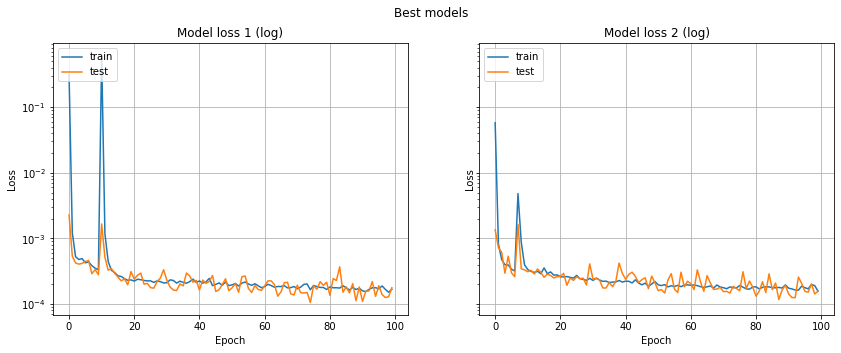

In [40]:
fig, axs = plt.subplots(1, len(models), figsize=(14,5), sharey='row')
fig.suptitle('Best models')
titles = []
for k in range(len(models)):
    titles.append(f"Model loss {k+1} (log)")
    axs[k].plot(histories[k].history['loss'])
    axs[k].plot(histories[k].history['val_loss'])
#     print(titles[-1])
    axs[k].set_title(titles[-1])
    axs[k].set_yscale("log")
    axs[k].legend(['train', 'test'], loc='upper left')
    axs[k].grid()

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Loss')
plt.show()

### Gráficas de comparación

In [41]:
Y_pred1 = models[0].predict(X)
Y_pred2 = models[1].predict(X)

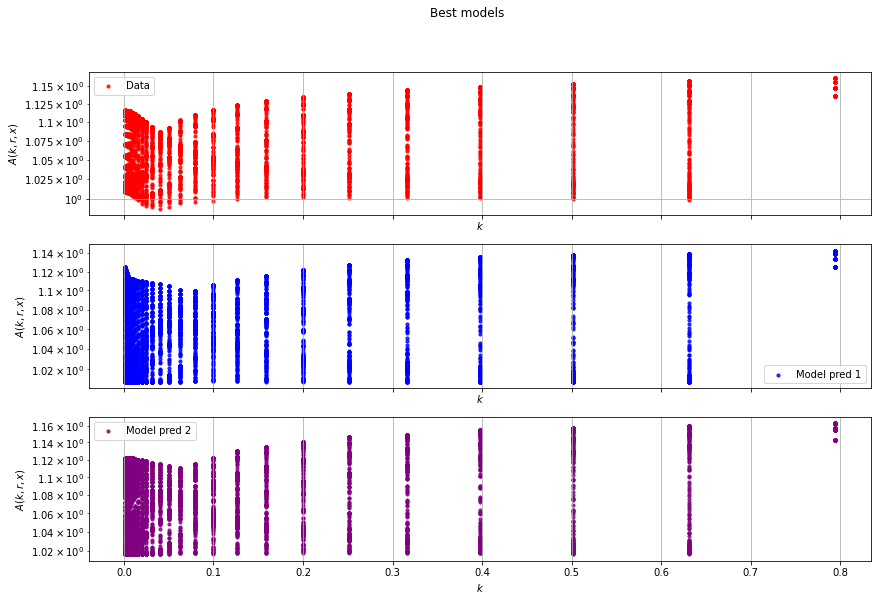

In [42]:
fig, axs = plt.subplots(1+len(models), figsize=(14,9), sharex="col")
fig.suptitle('Best models')

axs[0].scatter(X[:,0], Y, s=1e1, alpha=0.8, c='red', label="Data")
axs[0].set_yscale("log"); axs[0].grid(); axs[0].legend()

axs[1].scatter(X[:,0], Y_pred1, s=1e1, alpha=0.8, c='blue', label="Model pred 1")
axs[1].set_yscale("log"); axs[1].grid(); axs[1].legend()

axs[2].scatter(X[:,0], Y_pred2, s=1e1, alpha=0.8, c='purple', label="Model pred 2")
axs[2].set_yscale("log"); axs[2].grid(); axs[2].legend()

for ax in axs.flat:
    ax.set(xlabel=r'$k$', ylabel='$A(k,r,x)$')
plt.show()

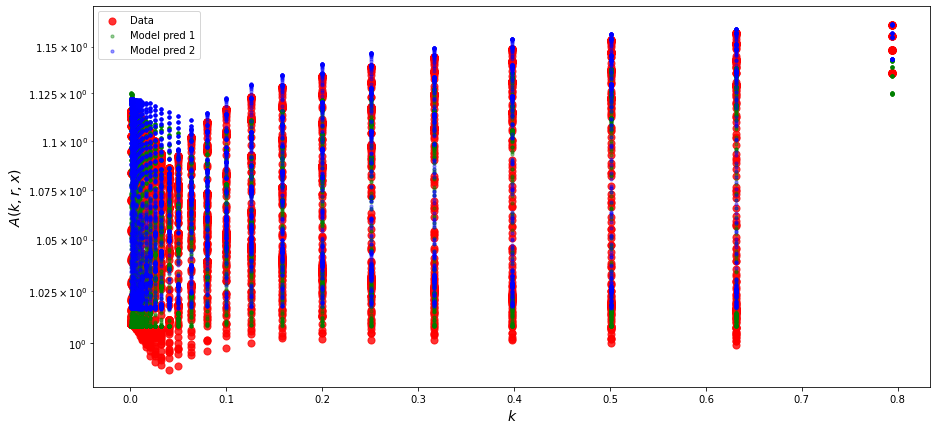

In [43]:
plt.figure(figsize=(15,7))
plt.scatter(X[:,0], Y, s=5e1, alpha=0.8, c='red', label="Data")
plt.scatter(X[:,0], Y_pred1, s=1e1, alpha=0.4, c='green', label="Model pred 1")
plt.scatter(X[:,0], Y_pred2, s=1e1, alpha=0.4, c='blue', label="Model pred 2")
plt.xlabel('$k$', fontsize=14); plt.ylabel(r'$A(k,r,x)$', fontsize=14)
plt.yscale('log'); plt.legend()
plt.show()

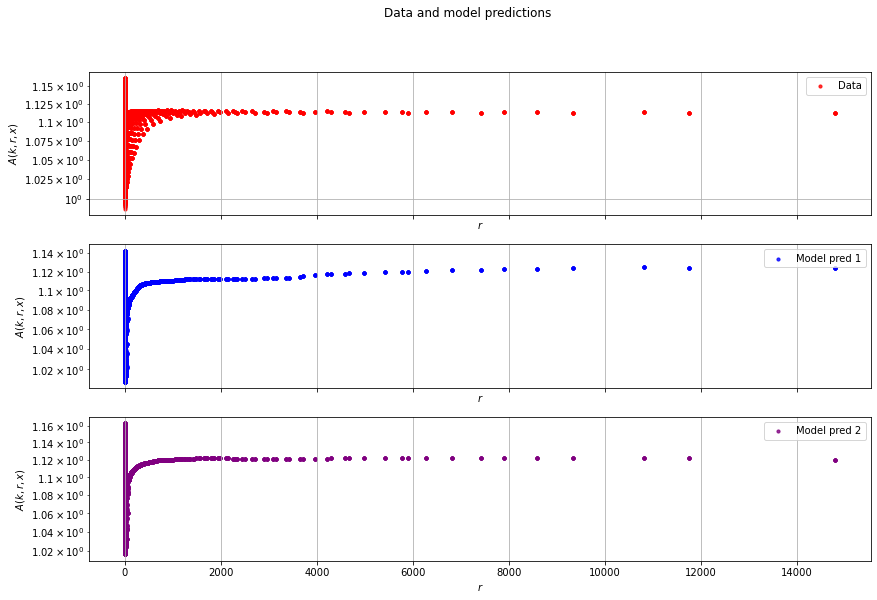

In [44]:
fig, axs = plt.subplots(1+len(models), figsize=(14,9), sharex="col")
fig.suptitle('Data and model predictions')

axs[0].scatter(X[:,1], Y, s=1e1, alpha=0.8, c='red', label="Data")
axs[0].set_yscale("log"); axs[0].grid(); axs[0].legend()

axs[1].scatter(X[:,1], Y_pred1, s=1e1, alpha=0.8, c='blue', label="Model pred 1")
axs[1].set_yscale("log"); axs[1].grid(); axs[1].legend()

axs[2].scatter(X[:,1], Y_pred2, s=1e1, alpha=0.8, c='purple', label="Model pred 2")
axs[2].set_yscale("log"); axs[2].grid(); axs[2].legend()

for ax in axs.flat:
    ax.set(xlabel=r'$r$', ylabel='$A(k,r,x)$')
plt.show()

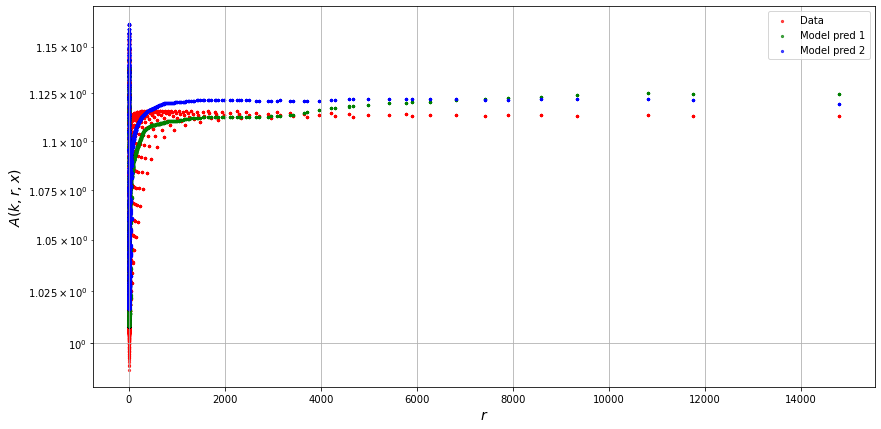

In [45]:
plt.figure(figsize=(14,7))
plt.scatter(X[:,1], Y, s=5e0, alpha=0.7, c='red', label="Data")
plt.scatter(X[:,1], Y_pred1, s=5e0, alpha=0.7, c='green', label="Model pred 1")
plt.scatter(X[:,1], Y_pred2, s=5e0, alpha=0.7, c='blue', label="Model pred 2")
plt.xlabel('$r$', fontsize=14); plt.ylabel(r'$A(k,r,x)$', fontsize=14)
plt.yscale('log'); plt.legend(); plt.grid();
plt.show()

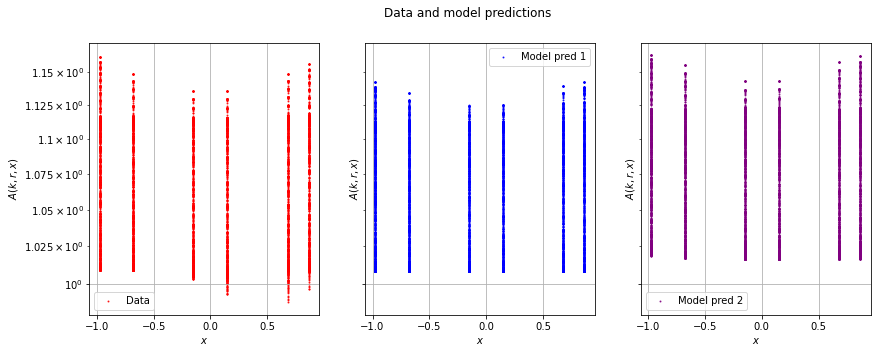

In [46]:
fig, axs = plt.subplots(1,1+len(models), figsize=(14,5), sharey="row")
fig.suptitle('Data and model predictions')

axs[0].scatter(X[:,2], Y, s=1e0, alpha=0.8, c='red', label="Data")
axs[0].set_yscale("log"); axs[0].grid(); axs[0].legend()

axs[1].scatter(X[:,2], Y_pred1, s=1e0, alpha=0.8, c='blue', label="Model pred 1")
axs[1].set_yscale("log"); axs[1].grid(); axs[1].legend()

axs[2].scatter(X[:,2], Y_pred2, s=1e0, alpha=0.8, c='purple', label="Model pred 2")
axs[2].set_yscale("log"); axs[2].grid(); axs[2].legend()

for ax in axs.flat:
    ax.set(xlabel=r'$x$', ylabel='$A(k,r,x)$')
plt.show()

### Comparación 3D

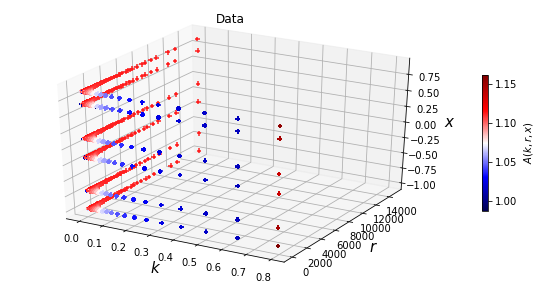

In [47]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X[:,0], X[:,1], X[:,2], marker='+', c=Y, cmap='seismic', alpha=1)
ax.set_xlabel('$k$', fontsize=15)
ax.set_ylabel('$r$', fontsize=15)
ax.set_zlabel('$x$', fontsize=15)
plt.colorbar(p, shrink=0.5, label='$A(k, r, x)$'); plt.title(r"Data")
plt.show()

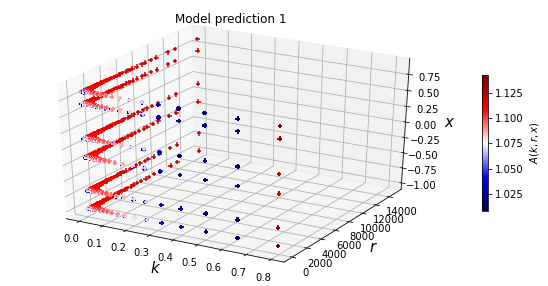

In [48]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X[:,0], X[:,1], X[:,2], marker='+', c=Y_pred1, cmap='seismic', alpha=1)
ax.set_xlabel('$k$', fontsize=15)
ax.set_ylabel('$r$', fontsize=15)
ax.set_zlabel('$x$', fontsize=15)
plt.colorbar(p, shrink=0.5, label='$A(k, r, x)$'); plt.title(r"Model prediction 1")
plt.show()

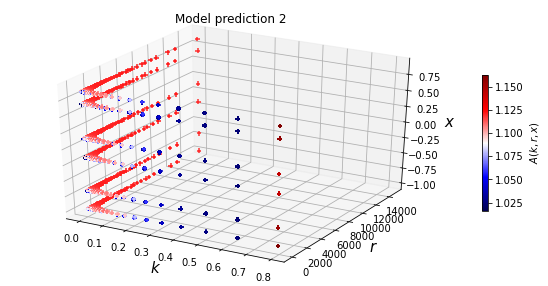

In [49]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X[:,0], X[:,1], X[:,2], marker='+', c=Y_pred2, cmap='seismic', alpha=1)
ax.set_xlabel('$k$', fontsize=15)
ax.set_ylabel('$r$', fontsize=15)
ax.set_zlabel('$x$', fontsize=15)
plt.colorbar(p, shrink=0.5, label='$A(k, r, x)$'); plt.title(r"Model prediction 2")
plt.show()

### Resultado de hiperparámetros

In [115]:
# Guarda las mejores N soluciones - (1, para k=1)
best_individuals2 = tools.selBest(population,k = 20)
best_deep_size2 = []
best_num_units2 = []
best_learning_rate2 = []
best_batch_size2 = []
best_epochs2 = []
t = 0

for bi in best_individuals2:
    deep_size_bits2 = BitArray(bi[0:3])
    num_units_bits2 = BitArray(bi[3:8])
    learning_rate_bits2 = BitArray(bi[8:12])
    batch_size_bits2 = BitArray(bi[12:14])
    epochs_bits2 = BitArray(bi[14:])
    t += 1 
    
    best_deep_size2.append(2*deep_size_bits2.uint +2)
    best_num_units2.append(2*num_units_bits2.uint +1)
    best_learning_rate2.append((2*learning_rate_bits2.uint + 1)*10**(-4))
    best_batch_size2.append(2**(batch_size_bits2.uint +1))
    best_epochs2.append((epochs_bits2.uint +1)*50)
#     print('k=',t,'\nDeep Size: ', best_deep_size2[-1], ', Num of Units: ', best_num_units2[-1], ', Learning rate: ', best_learning_rate2[-1])
#     print('Batch Size: ', best_batch_size2[-1], ", Num of Epochs: ", best_epochs2[-1])

[Text(0, 0.5, 'Batch size'), Text(0.5, 0, 'Learning rate')]

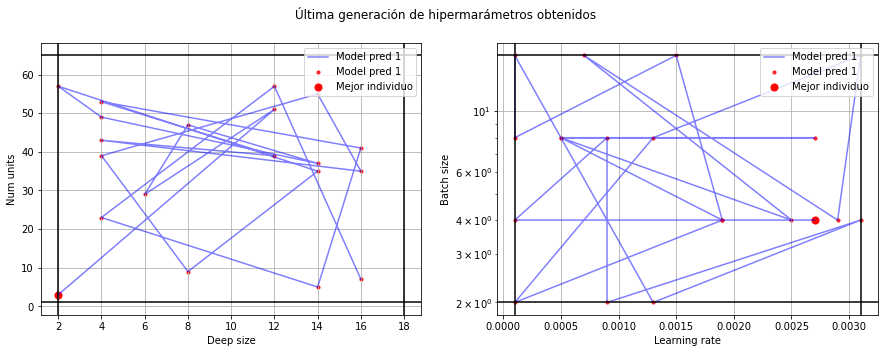

In [116]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

fig.suptitle('Última generación de hipermarámetros obtenidos')

axs[0].plot(best_deep_size2, best_num_units2, alpha=0.5, c='blue', label="Model pred 1")
axs[0].scatter(best_deep_size2, best_num_units2, s=10, alpha=0.8, c='red', label="Model pred 1")
axs[0].scatter(best_deep_size2[0], best_num_units2[0], s=50, alpha=1, c='red', label="Mejor individuo")
axs[0].grid(); axs[0].legend(loc='upper right'); 
# axs[0].set_xlim([2, 18]); axs[0].set_ylim([1, 65])
axs[0].axvline(2, c="black"); axs[0].axvline(18, c="black");
axs[0].axhline(1, c="black"); axs[0].axhline(65, c="black");
# axs[0].axhline([1, 65])
axs[0].set(xlabel=r'Deep size', ylabel='Num units')

axs[1].plot(best_learning_rate2, best_batch_size2, alpha=0.5, c='blue', label="Model pred 1")
axs[1].scatter(best_learning_rate2, best_batch_size2, s=10, alpha=0.8, c='red', label="Model pred 1")
axs[1].scatter(best_learning_rate2[0], best_batch_size2[0], s=50, alpha=1, c='red', label="Mejor individuo")
axs[1].set_yscale("log"); 
axs[1].grid(); axs[1].legend(loc='upper right')
# axs[1].set_xlim([1e-4, 31e-4]); axs[1].set_ylim([2**1, 2**4])
axs[1].axvline(1e-4, c="black"); axs[1].axvline(31e-4, c="black");
axs[1].axhline(2**1, c="black"); axs[1].axhline(2**4, c="black");
axs[1].set(xlabel=r'Learning rate', ylabel='Batch size')